<a href="https://colab.research.google.com/github/sh-Gabriel/Atrial-Enlargement-Detection/blob/main/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports e mount


In [ ]:
#imports
from google.colab         import drive
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
from   matplotlib          import pyplot
# from google.colab.patches import cv2_imshow

import numpy as np
from   numpy import expand_dims

import pandas as pd
import cv2    as cv
import random
import os
import glob
import csv
import statistics

from io import BytesIO

from PIL import Image

from itertools import islice

import tensorflow                as tf
from   tensorflow                import keras, numpy_function
# from   tensorflow.keras.utils    import load_img, img_to_array
# from   tensorflow.image          import adjust_contrast

# import tensorflow_addons as tfa

#from   tensorflow.keras.preprocessing.image import img_to_array

from keras                     import layers
from keras.callbacks           import EarlyStopping,ModelCheckpoint
from keras.applications.vgg16  import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator

from sklearn                 import metrics, svm
from sklearn.utils           import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.base            import BaseEstimator, TransformerMixin
from sklearn.pipeline        import Pipeline
from sklearn.metrics         import ConfusionMatrixDisplay
from sklearn.metrics         import confusion_matrix

#augmentation
import matplotlib.pyplot as plt

# import mxnet                   as mx
# from   mxnet.gluon.data.vision import transforms

from sklearn.model_selection import KFold

import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report
from yellowbrick.classifier import ConfusionMatrix
#!pip3 install tensorflow-addons

In [ ]:
#mount and defines

# drive.mount('/content/drive/MyDrive/TCC/',force_remount=True)
drive.mount('/content/drive',force_remount=True)
PATH             = 'drive/MyDrive/TCC/Dataset_V2/'
norm             = "N"
doente           = "AAE"
left             = "Torax_LAT_E"
right            = "Torax_LAT_D"
stop_n = stop_s  = 30
current_s        = 6
# Imagem é mto grande para ser alocada na gpu, não dá pra usar esses valores
# shape_w, shape_h = 2928, 2328
shape_w, shape_h = 224,224
number_of_folds  = 4 #4-fold cross validation + holdout set
np.random.seed(42)
# !git clone https://github.com/pjreddie/darknet.git
# !cd drive/MyDrive/TCC/darknet; make

Mounted at /content/drive


# GPU e memoria


Os usuários que compraram um dos planos pagos do Colab têm acesso a GPUs premium. É possível fazer upgrade das configurações de GPU do notebook em Runtime > Change runtime type no menu para ativar o acelerador Premium. Sujeito à disponibilidade, ao selecionar uma GPU premium, talvez você ganhe acesso a uma GPU Nvidia V100 ou A100.

A versão sem custo financeiro do Colab dá acesso às GPUs T4 da Nvidia, sujeito a restrições de cota e disponibilidade.

É possível ver qual é a GPU atribuída a qualquer momento, executando a célula a seguir. Se o resultado da execução da célula de código abaixo for "Not connected to a GPU", mude o ambiente. Acesse Runtime > Change runtime type no menu para ativar um acelerador de GPU, depois execute novamente a célula de código.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Feb 22 14:48:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Os usuários que compraram um dos planos pagos do Colab têm acesso a VMs de alta memória quando estão disponíveis. É possível ver quanta memória há disponível a qualquer momento, executando a célula de código. Se o resultado da execução da célula de código abaixo for "Not using a high-RAM runtime", ative um ambiente com RAM alta. Acesse Runtime > Change runtime type no menu. Depois selecione "RAM alta" no menu suspenso "Características do ambiente de execução". Por fim, execute a célula de código novamente.

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


# Imagens

In [ ]:
def openImgs(classe,lateralidade):
  r_v = 0
  for subdir, dirs, files in os.walk(PATH+classe):
    if (files and lateralidade in subdir):
      r_v += 1
  print(r_v)

In [ ]:
openImgs(norm,left)

32


In [ ]:
openImgs(doente,left)

95


Coloquei os defs e a chamada do join_open_files tudo junto, porque basicamente eles fazem uma coisa só que é o join_open_files e assim, não precisa ficar rodando os defs de novo toda vez que muda alguma coisa

In [ ]:
def rotation(img):
  dim = img.shape[:2]
  center = (dim[0]/2, dim[1]/2)
  rot = cv.getRotationMatrix2D(center, 15, 1)
  rotated = cv.warpAffine(img, rot,dim)
  # cv2_imshow(rotated)
  return rotated

def translation(img):
  T = np.float32([[1, 0, 0], [0, 1, -50]])
  translated = cv.warpAffine(img, T, img.shape[:2])
  # cv2_imshow(translated)
  return translated

def enbrighten(img):
  sam = expand_dims(img, 0)
  imageDataGenerator_obj = ImageDataGenerator(brightness_range=[0.9,0.9])
  iterator = imageDataGenerator_obj.flow(sam, batch_size=1)
  result = iterator.next()[0].astype('uint8')
  # cv2_imshow(result)
  return result

def change_contrast(img):
  contrast = tf.keras.layers.RandomContrast(0.3, seed = 42)
  # cv2_imshow(contrast(img).numpy().astype('uint8'))
  imageDataGenerator_obj = ImageDataGenerator(brightness_range=[0.2,1.0])
  # cv2_imshow(contrast(img).numpy().astype('uint8'))
  return contrast(img).numpy().astype('uint8')

In [ ]:
def openImgs(classe,lateralidade):
  r_v = []
  for subdir, dirs, files in os.walk(PATH+classe):
    if (files and lateralidade in subdir):
      r_v += [subdir+'/'+files[0]]
  return shuffle(r_v, random_state = 42)

In [ ]:
def join(lateralidade=left):
  X=[] # Images
  Y=[] # type of image (normal or AE)

  for f in islice(openImgs(norm, lateralidade), 0, stop_n):
    X.append(cv.resize(cv.imread(f), (shape_w, shape_h))) #Original image 'normal'
    Y += [0]


  for f in islice(openImgs(doente, lateralidade), 0, stop_s):
    X.append(cv.resize(cv.imread(f), (shape_w, shape_h))) #Original image 'atrial enlargement'
    Y += [1]

  return np.array(X), np.array(Y)

In [ ]:
def join1Aug(lateralidade=left):
  X=[] # Images
  Y=[] # type of image (normal or AE)

  for f in islice(openImgs(norm, lateralidade), 0, stop_n):
    cv2_imshow(cv.imread(f))
    X.append(cv.resize(cv.imread(f), (shape_w, shape_h))) #Original image 'normal'
    X.append(cv.resize( (rotation(cv.imread(f)) )       , (shape_w, shape_h) ) ) #data augmentation
    X.append(cv.resize( (translation(cv.imread(f)) )    , (shape_w, shape_h) ) )
    X.append(cv.resize( (enbrighten(cv.imread(f))  )    , (shape_w, shape_h) ) )
    X.append(cv.resize( (change_contrast(cv.imread(f)) ), (shape_w, shape_h) ) )
    Y += [0]*5

  for f in islice(openImgs(doente, lateralidade), 0, stop_s):
    X.append(cv.resize(cv.imread(f), (shape_w, shape_h))) #Original image 'atrial enlargement'
    X.append(cv.resize( (rotation(cv.imread(f)) )       , (shape_w, shape_h) ) ) #data augmentation
    X.append(cv.resize( (translation(cv.imread(f)) )    , (shape_w, shape_h) ) )
    X.append(cv.resize( (enbrighten(cv.imread(f))  )    , (shape_w, shape_h) ) )
    X.append(cv.resize( (change_contrast(cv.imread(f)) ), (shape_w, shape_h) ) )
    Y += [1]*5

  return np.array(X), np.array(Y)

In [ ]:
def joinManyAug(lateralidade=left):
  X=[] # Images
  Y=[] # type of image (normal or AE)

  for f in islice(openImgs(norm, lateralidade), 0, stop_n):
    X.append(cv.resize(cv.imread(f), (shape_w, shape_h))) #Original image 'normal'

    X.append(cv.resize( (rotation(cv.imread(f)) ), (shape_w, shape_h) ) ) #data augmentation
    X.append(cv.resize( (rotation((enbrighten(cv.imread(f)))) ) , (shape_w, shape_h) ) )
    X.append(cv.resize( (rotation((change_contrast(cv.imread(f)))) ) , (shape_w, shape_h) ) )

    X.append(cv.resize( (translation(cv.imread(f)) ), (shape_w, shape_h) ) )
    X.append(cv.resize( (translation((enbrighten(cv.imread(f)))) ), (shape_w, shape_h) ) )
    X.append(cv.resize( (translation((change_contrast(cv.imread(f)))) ), (shape_w, shape_h) ) )

    X.append(cv.resize( (enbrighten(cv.imread(f))  )    , (shape_w, shape_h) ) )

    X.append(cv.resize( (change_contrast(cv.imread(f)) ), (shape_w, shape_h) ) )

    X.append(cv.resize( (enbrighten((change_contrast(cv.imread(f))))  )    , (shape_w, shape_h) ) )

    Y += [0]*10


  for f in islice(openImgs(doente, lateralidade), 0, stop_s):
    X.append(cv.resize(cv.imread(f), (shape_w, shape_h))) #Original image 'normal'

    X.append(cv.resize( (rotation(cv.imread(f)) ), (shape_w, shape_h) ) ) #data augmentation
    X.append(cv.resize( (rotation((enbrighten(cv.imread(f)))) ) , (shape_w, shape_h) ) )
    X.append(cv.resize( (rotation((change_contrast(cv.imread(f)))) ) , (shape_w, shape_h) ) )

    X.append(cv.resize( (translation(cv.imread(f)) ), (shape_w, shape_h) ) )
    X.append(cv.resize( (translation((enbrighten(cv.imread(f)))) ), (shape_w, shape_h) ) )
    X.append(cv.resize( (translation((change_contrast(cv.imread(f)))) ), (shape_w, shape_h) ) )

    X.append(cv.resize( (enbrighten(cv.imread(f))  )    , (shape_w, shape_h) ) )

    X.append(cv.resize( (change_contrast(cv.imread(f)) ), (shape_w, shape_h) ) )

    X.append(cv.resize( (enbrighten((change_contrast(cv.imread(f))))  )    , (shape_w, shape_h) ) )

    Y += [1]*10

  return np.array(X), np.array(Y)

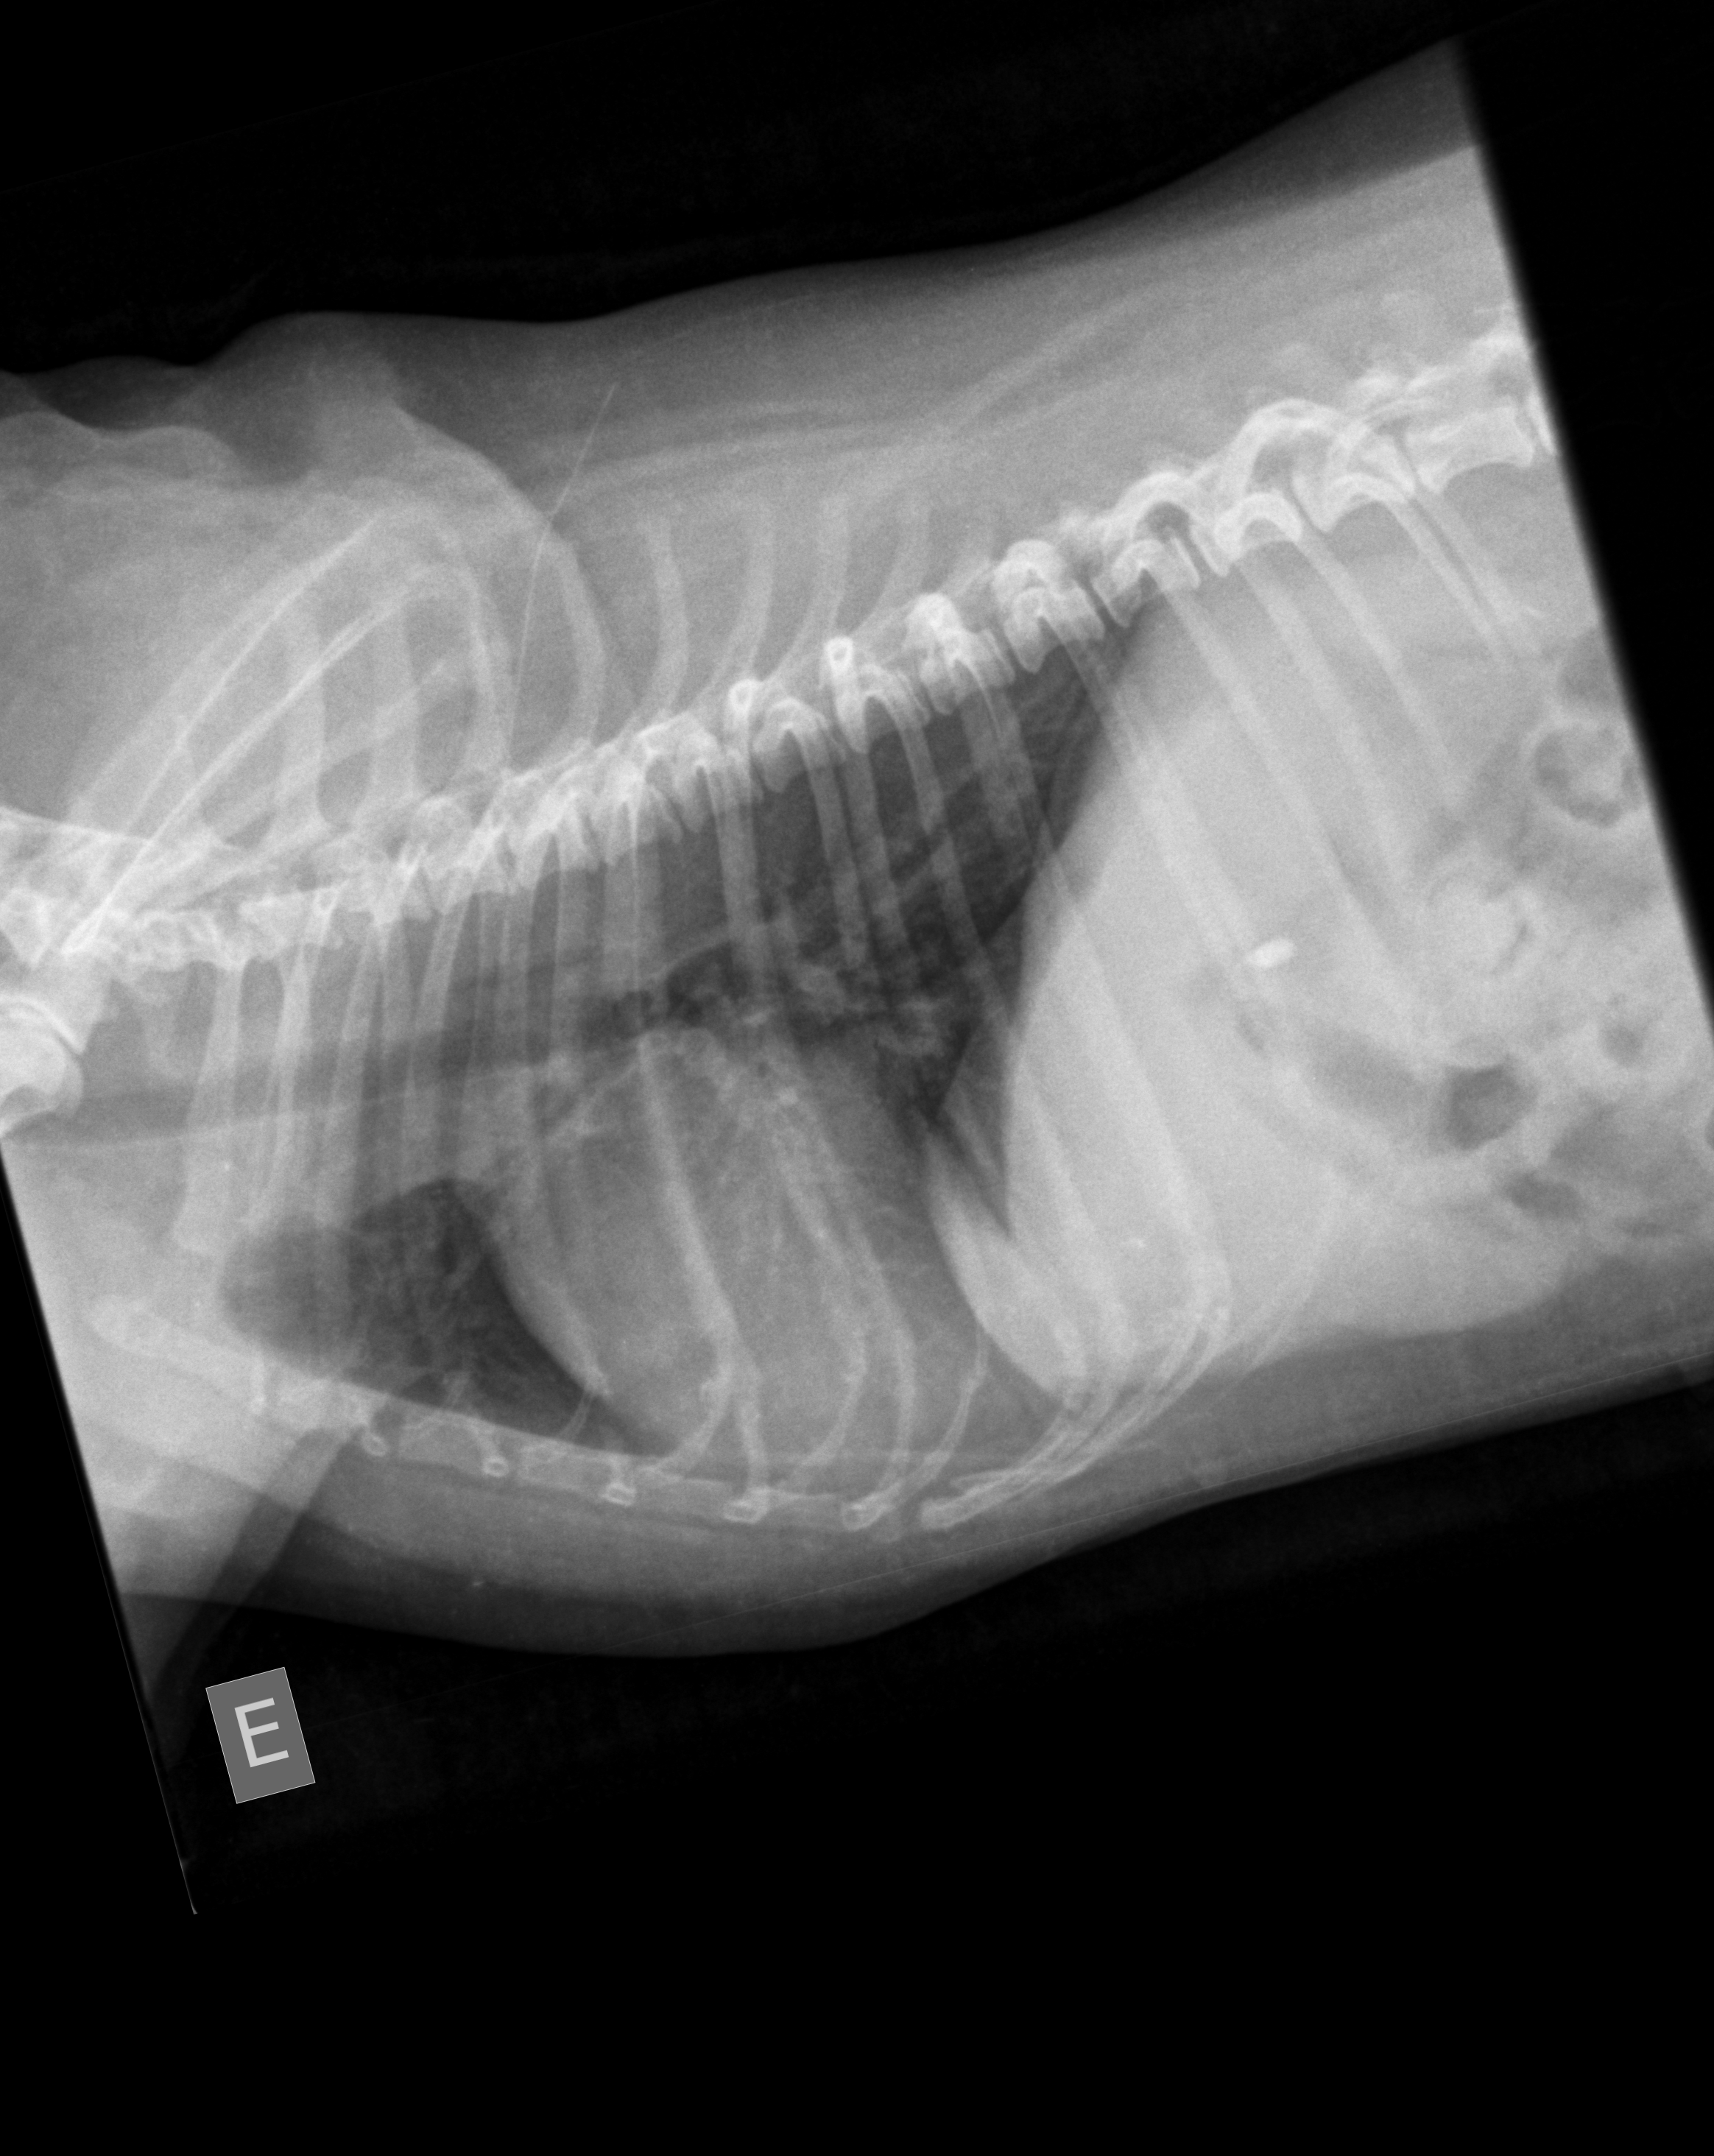

In [ ]:
xm, ym = join1Aug();

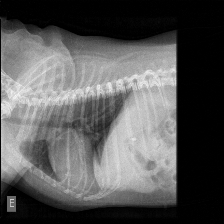

In [ ]:
from google. colab. patches import cv2_imshow

cv2_imshow(xm[0])

# Redes

In [ ]:
def custom_VGG16():
  vgg16 = keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet", classes=2);

  last_layer = vgg16.get_layer('block5_pool')
  last_output = last_layer.output
  extraLayer = tf.keras.layers.GlobalMaxPooling2D()(last_output)
  extraLayer = tf.keras.layers.Dense(512, activation='relu')(extraLayer)
  extraLayer = tf.keras.layers.Dropout(0.5)(extraLayer)
  extraLayer = tf.keras.layers.Dense(2, activation='sigmoid')(extraLayer)

  vgg16 = keras.Model(vgg16.input, extraLayer)
  return vgg16

# model = custom_VGG16()


In [ ]:
def custom_VGG19():
  vgg19 = keras.applications.VGG19(input_shape=(shape_h, shape_w, 3), include_top=False, weights="imagenet", classes=2);

  last_layer = vgg19.get_layer('block5_pool')
  last_output = last_layer.output
  extraLayer = tf.keras.layers.GlobalMaxPooling2D()(last_output)
  extraLayer = tf.keras.layers.Dense(512, activation='relu')(extraLayer)
  extraLayer = tf.keras.layers.Dropout(0.5)(extraLayer)
  extraLayer = tf.keras.layers.Dense(2, activation='sigmoid')(extraLayer)

  vgg19 = keras.Model(vgg19.input, extraLayer)

  return vgg19

# model = custom_VGG19()
# model.summary()

In [ ]:
def custom_InceptionV3():
  iv3 = keras.applications.InceptionV3(input_shape=(shape_w, shape_h, 3), include_top=False, weights="imagenet");

  last_layer  = iv3.get_layer('mixed10')
  last_output = last_layer.output
  extraLayer = tf.keras.layers.GlobalMaxPooling2D()(last_output)
  extraLayer = tf.keras.layers.Dense(512, activation='relu')(extraLayer)
  extraLayer = tf.keras.layers.Dropout(0.5)(extraLayer)
  extraLayer = tf.keras.layers.Dense(2, activation='sigmoid')(extraLayer)

  model = keras.Model(iv3.input, extraLayer)

  return model

# model = custom_InceptionV3()
# model.summary()

In [ ]:
def custom_ResNet50V2():
  resnet = keras.applications.ResNet50V2(input_shape=(shape_w, shape_h, 3), include_top=False, weights='imagenet');

  last_layer = resnet.get_layer('conv5_block3_out')
  last_output = last_layer.output
  extraLayer = tf.keras.layers.GlobalMaxPooling2D()(last_output)
  extraLayer = tf.keras.layers.Dense(512, activation='relu')(extraLayer)
  extraLayer = tf.keras.layers.Dropout(0.5)(extraLayer)
  extraLayer = tf.keras.layers.Dense(2, activation='sigmoid')(extraLayer)

  resnet = keras.Model(resnet.input, extraLayer)
  return resnet

# model = custom_ResNet50V2()
# model.summary()

# Cross Validation


achar os melhores pesos para cada fold e no final fazer uma média deles

testar com 5, 6 e 10 folds

separar as imagens em 5 pastas com 12 imagens

*  separar 1 pasta pra teste
*  1 pasta pra validação
*  3 pastas pra treino


*  testar com 5 folds
*  1 fold com 12 imagens sem aug
*  sobraram 48
*  data aug das 48
*  shuffle das 48 pra treino


In [ ]:
def custom_kfold(X, y, model, name, learning_rate, logger, metric, vecAcc):
  fold_var = 1
  # kf = KFold(number_of_folds)
  confMatrix = [0,0,0,0]
  KF = KFold(n_splits = number_of_folds, shuffle = True)
  vecY_pred = []
  vecY_test = []
  #randomizar um pouco a proporção das classes pode ser uma boa, desde que garanta o holdout possuir ambas.
  # X_fold = np.concatenate([X[:24], X[30:54]])
  # y_fold = np.concatenate([y[:24], y[30:54]])

  # X_holdout = np.concatenate([X[24:30], X[54:60]])
  # y_holdout = np.concatenate([y[24:30], y[54:60]])
  # print(f"Holdout: \n{X_holdout.shape}\n{y_holdout}\nInicialmente balanceado.")

  # kf.get_n_splits(X)
  results = []
  nsamples, nx, ny, channels = X.shape

  checkpoint_path = 'drive/MyDrive/TCC/checkpoints/'
  checkpoint_name = name+'pesos.tf'

  logger.info("Starting "f"{name}")

  #rascunhos
  # opt = keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(loss=LOSS, optimizer=opt, metrics=['accuracy'])
  print(X.shape)
  print(y.shape)

  # for train_index, test_index in kf.split(X_fold):
  for j, (train_index, test_index) in enumerate(KF.split(X)):
    # print(f"Current fold: {fold_var}")
                      #----- Mudei os vermose pra 0 no ModelCheckpoint e no fit pra não aparecer os prints -----#
    # checkpoint = ModelCheckpoint(filepath=checkpoint_path+checkpoint_name, monitor='val_accuracy', verbose = 0, mode='max', save_weights_only=True)
    checkpoint = ModelCheckpoint(filepath=checkpoint_path+checkpoint_name, monitor='accuracy', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)
    early = EarlyStopping(monitor='accuracy', min_delta=0, patience=20, verbose=0, mode='auto')
    #callback_list = [checkpoint]

    # X_train, X_test = X_fold[train_index], X_fold[test_index]
    # y_train, y_test = y_fold[train_index], y_fold[test_index]
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(f"index: {train_index, test_index}")
    print(f"shapes: {X_train.shape, X_test.shape, y_train.shape, y_test.shape}")


    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    # history = model.fit(X_train, y_train, steps_per_epoch = 5, validation_split = 0.1, validation_steps = 5, epochs = EPOCHS, callbacks = [checkpoint, early], verbose = 0)
    history = model.fit(X_train, y_train, epochs = EPOCHS, callbacks=checkpoint, validation_split = 0.1, verbose = 0)
    # transfer_model.fit(train1_data, train1_labels, batch_size = 15, epochs=5, validation_data=(test1_data, test1_labels) callbacks=[lr_reduce,checkpoint])

    y_pred = model.predict(X_test, callbacks=checkpoint)
    print(f"y_pred_true: {y_pred}")

    y_pred = np.argmax(y_pred, axis=1)
    vecY_pred.append(y_pred)

    print(f"y_test: {y_test}")
    print(f"y_pred: {y_pred}")

    print(classification_report(y_test, y_pred, zero_division = 0))
    # xasd = classification_report(y_test, y_pred)
    # h.append(xasd)

    # metrics(metric, history, y_test, y_pred, )

    model.load_weights(checkpoint_path+name+'pesos.tf')

    results += [["accuracy", model.evaluate(X_test, y_test)[1]]]
    print(f"results: {metric}")

    loss, acc = model.evaluate(X_test, y_test)
    vecY_test.append(y_test)
    vecAcc.append(acc)
    # results = dict(zip(model.metrics_names, results))
    tf.keras.backend.clear_session()

    fold_var += 1

    # displayHistory(history)
    logger.info("Preliminar result "f"{results[-1]}")
  # holdout_pred = model.evaluate(X_holdout, y_holdout)
  # logger.info("Holdout pred "f"{holdout_pred} for "f"{name}")
  # print(f"\nValidation using the holdout data: {holdout_pred}")

  logger.info(f"{name} finished.")

  return vecY_pred, vecY_test

In [ ]:
def run (network, networkName, learningRate, metric, vecA):
  logg = networkName+".logs"
  logger = log("drive/MyDrive/TCC/logs/", logg)
  vecY_pred, vecY_test = custom_kfold(X, y, network, networkName, learningRate, logger, metric, vecA)
  logging.shutdown()
  return vecY_pred, vecY_test


In [ ]:
def run1 (network, networkName, learningRate, metric):
  logg = networkName+".logs"
  logger = log("drive/MyDrive/TCC/logs/", logg)
  houdout_pred = custom_kfold(X1, y1, network, networkName, learningRate, logger, metric)
  logging.shutdown()


In [ ]:
def runm (network, networkName, learningRate, metric):
  logg = networkName+".logs"
  logger = log("drive/MyDrive/TCC/logs/", logg)
  houdout_pred = custom_kfold(Xm, ym, network, networkName, learningRate, logger, metric)
  logging.shutdown()


In [ ]:
# X, y = join()

In [ ]:
# X1, y1 = join1Aug()

In [ ]:
# Xm, ym = joinManyAug()

In [ ]:
# Xm.shape

In [ ]:
# from keras import applications.vgg16.preprocess_input

In [ ]:
def main(network, networkName, dataBaseType):
  resAux = [[],[],[],[],[],[]]
  vecA   = []
  if(dataBaseType == 0):
    for i in range(num_rep):
     vecY_pred, vecY_test = run(network, networkName, learning_rate, resAux, vecA)
  elif(dataBaseType == 1):
    for i in range(num_rep):
     run1(network, networkName, learning_rate, resAux, vecA)
  elif(dataBaseType == 2):
    for i in range(num_rep):
     runm(network, networkName, learning_rate, resAux, vecA)
  else:
    return 0

  # for i in range(len(resAux)):
  #   resAux[i] = [item for sublist in resAux[i] for item in sublist]
  # for i in range(len(vecA)):
  #   vecA = [item for sublist in vecA[i] for item in sublist]

  # resultados = pd.DataFrame({'Accuracy': vecA, 'Sensibility': resAux[0], 'Specificity': resAux[1],
                              # 'Precision': resAux[2], 'Recall': resAux[3], 'F1Score': resAux[4]})

  return vecY_pred, vecY_test

# Leave One Out

In [ ]:
def join(lateralidade=left):
  X=[] # Images
  Y=[] # type of image (normal or AE)

  for f in islice(openImgs(norm, lateralidade), 0, stop_n):
    X.append(cv.resize(cv.imread(f), (shape_w, shape_h))) #Original image 'normal'
    Y += [0]

  for f in islice(openImgs(doente, lateralidade), 0, stop_s):
    X.append(cv.resize(cv.imread(f), (shape_w, shape_h)))  #Original image 'atrial enlargement'
    Y += [1]

  return X, Y

In [ ]:
def shuffle_Xy():
  shape_w, shape_h = 2928, 2328
  X, y = join()

  # Shuffle two lists with same order
  # Using zip() + * operator + shuffle()
  temp = list(zip(X, y))
  random.shuffle(temp)
  auxX, auxY = zip(*temp)
  # res1 and res2 come out as tuples, and so must be converted to lists.
  X, y = list(auxX), list(auxY)
  return X, y

In [ ]:
def printRange(a, b):
  valPrint = [item for item in range(a, b+1)]
  print(valPrint)

In [ ]:
from keras.backend import ndim
def LOO(X, y, model, name, lr):
    KF = KFold(n_splits = 60, shuffle= False)
    val_max2 = 59
    vecY_predT = []
    vecY_predV = []
    vecAccT = []
    vecAccV = []
    vecY_val = []
    vecY_test = []
    lossValVec = []
    lossTestVec = []
    confMatrix = [0,0,0,0]

    checkpoint_path = 'drive/MyDrive/TCC/checkpoints/'
    checkpoint_name = name+'pesos.tf'

    for index, (train_index, test_index) in enumerate(KF.split(X)):
      print(f"Index: {index}")
      if(index > 53):
        val_min = index + 1
        val_max = 59
        val_max2 = (val_min + 5)%60
      else:
        val_min = index + 1
        val_max = val_min + 5

      comeco_comeco = val_min - index - 1
      fim_comeco = index - 1
      comeco_fim = val_max + 1
      fim_fim = val_max2

      X_test, y_test = X[index], y[index]
      X_train, y_train = [], []
      validation_X, validation_y = [], []

      if(fim_comeco == -1): # index 0, validation de 1 a 5, logo treino de 6 a 59
        # validationX = list(range(val_min,val_max))
        # train_index = list(range(comeco_fim-1,fim_fim+1))
        validationX = X[val_min:val_max+1]
        validationY = y[val_min:val_max+1]
        X_train = X[comeco_fim:fim_fim+1]
        y_train = y[comeco_fim:fim_fim+1]
        # print(index)
        # printRange(val_min, val_max+1)
        # printRange(comeco_fim, fim_fim+1)

      if(comeco_comeco <= fim_comeco) and (comeco_comeco == 0): #index a partir do 1 até 53, val_min/val_max de 2/7 até 53/58
        if(fim_comeco < 52):
          # validationX = (range(val_min, val_max+1))
          # train_index = list(range(comeco_comeco, fim_comeco+1)) + list(range(comeco_fim, fim_fim+1))
          validationX = X[val_min:val_max+1]
          validationY = y[val_min:val_max+1]
          X_train = np.concatenate((X[comeco_comeco:fim_comeco+1], X[comeco_fim:fim_fim+1]))
          y_train = np.concatenate((y[comeco_comeco:fim_comeco+1], y[comeco_fim:fim_fim+1]))
          # print(index)
          # printRange(val_min, val_max+1)
          # printRange(comeco_comeco, fim_comeco+1)
          # printRange(comeco_fim, fim_fim+1)

        if(fim_comeco == 52):
          # validationX = list(range(val_min, val_max))
          # train_index = list(range(comeco_comeco, fim_comeco))
          validationX = X[val_min:val_max+1]
          validationY = y[val_min:val_max+1]
          X_train = X[comeco_comeco:fim_comeco+1]
          y_train = y[comeco_comeco:fim_comeco+1]
          # print(index)
          # printRange(val_min, val_max+1)
          # printRange(comeco_comeco, fim_comeco+1)

        if((fim_comeco > 52) and (val_min <= 59)):
          # validationX = list(range(val_min, 60)) + list(range(0, val_max2+1))
          # train_index = list(range(val_max2+1, fim_comeco+1))
          validationX = np.concatenate((X[val_min:60], X[0:val_max2+1]))
          validationY = np.concatenate((y[val_min:60], y[0:val_max2+1]))
          X_train = X[val_max2+1:fim_comeco+1]
          y_train = y[val_max2+1:fim_comeco+1]
          # print(index)
          # printRange(val_min, 60)
          # printRange(0, val_max2+1)
          # printRange(val_max2+1, fim_comeco+1)

        if(val_min == 60):
          validationX = X[0:val_max2+1]
          validationY = y[0:val_max2+1]
          X_train = X[val_max2+1:fim_comeco+1]
          y_train = y[val_max2+1:fim_comeco+1]
          # print(index)
          # printRange(0, val_max2+1)
          # printRange(val_max2+1, fim_comeco+1)


      X_train1 = []
      y_train1 = []

      for img, y1 in zip(X_train, y_train):
        X_train1.append(cv.resize(img, (224, 224)))                      #Original image 'normal'
        X_train1.append(cv.resize( (rotation(img) )       , (224, 224))) #data augmentation
        X_train1.append(cv.resize( (translation(img) )    , (224, 224)))
        X_train1.append(cv.resize( (enbrighten(img)  )    , (224, 224)))
        X_train1.append(cv.resize( (change_contrast(img) ), (224, 224)))
        y_train1 += [y1]*5

      X_train1 = np.array(X_train1)
      y_train1 = np.array(y_train1)

      X_val = []
      for img in validationX:
        X_val.append(cv.resize(img, (224, 224)))
      X_val = np.array(X_val)
      y_val = np.array(validationY)

      X_test = cv.resize(X_test, (224, 224))
      X_test.shape = (1, 224, 224, 3)
      y_test = np.array(y_test, ndmin = 1)

      checkpoint = ModelCheckpoint(filepath=checkpoint_path+checkpoint_name, monitor='accuracy', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

      model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                    optimizer=keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])

      # X_x = np.concatenate((X_train1, X_val))
      # Y_y = np.concatenate((y_train1, y_val))
      history = model.fit(X_train1, y_train1, epochs = 20, validation_split = 0, verbose = 0)

      lossVal, accVal = model.evaluate(X_val, y_val, callbacks=checkpoint)
      y_predV = model.predict(X_val)
      y_predV = np.argmax(y_predV, axis=1)
      vecAccV.append(accVal)
      vecY_predV.append(y_predV)
      vecY_val.append(y_val)

      lossValVec.append(lossVal)

      lossTest, accTest = model.evaluate(X_test, y_test)
      y_predT = model.predict(X_test)
      y_predT = np.argmax(y_predT, axis=1)
      vecAccT.append(accTest)
      vecY_predT.append(y_predT)
      vecY_test.append(y_test)

      lossTestVec.append(lossTest)

      tf.keras.backend.clear_session()

    return vecAccV, vecY_predV, vecY_val, vecAccT, vecY_predT, vecY_test, lossValVec, lossTestVec


In [ ]:
def main(network, networkName):
  resAux = [[],[],[],[],[],[]]
  # vecAccV, vecY_predV, vecY_val, vecAccT, vecY_predT, vecY_test = [], [], [], [], [], []
  vecAccV, vecY_predV, vecY_val, vecAccT, vecY_predT, vecY_test, lossValVec, lossTestVec = runLOO(network, networkName, learning_rate, resAux)
  # resultados = pd.DataFrame({'Accuracy Test': vecAT, 'Sensibility': resAux[0], 'Specificity': resAux[1],
  #                             'Precision': resAux[2], 'Recall': resAux[3], 'F1Score': resAux[4]})
  # print(len(vecAccV), len(vecY_predV), len(vecY_val), len(vecAccT), len(vecY_predT), len(vecY_test))
  # resultados = pd.DataFrame({'vecAccV': vecAccV, 'vecY_predV': vecY_predV.flatten(), 'vecY_val': vecY_val.flatten(),
  #                             'vecAccT': vecAccT, 'vecY_predT': vecY_predT, 'vecY_test': vecY_test})

  return vecAccV, vecY_predV, vecY_val, vecAccT, vecY_predT, vecY_test, lossValVec, lossTestVec

In [ ]:
def runLOO (network, networkName, learningRate, metric):
  logg = networkName+".logs"
  logger = log("drive/MyDrive/TCC/logs/", logg)
  X, y = shuffle_Xy()
  vecAccV, vecY_predV, vecY_val, vecAccT, vecY_predT, vecY_test, lossValVec, lossTestVec = LOO(X, y, network, networkName, learningRate)
  logging.shutdown()
  return vecAccV, vecY_predV, vecY_val, vecAccT, vecY_predT, vecY_test, lossValVec, lossTestVec

# Metrics e Log

In [ ]:
def displayHistory(history):
  figure, axis = plt.subplots(nrows=1, ncols=2)
  axis[0].plot(history.history['accuracy'])
  # axis[0].plot(history.history['val_accuracy'])
  axis[0].set_title('model accuracy')
  #plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  axis[1].plot(history.history['loss'])
  # axis[1].plot(history.history['val_loss'])
  axis[1].set_title('model loss')
  #plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  plt.show()

def confusionMatrix(y_test, y_pred):

  cm   = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix = cm)

  disp.plot(cmap = plt.cm.Blues)
  plt.show()

def calcConf (y_test, y_pred, confusionM):
  if ((y_test == y_pred) and (y_test == 1)):
    aux = confusionM[0]
    confusionM[0] = aux + 1
  if ((y_test == y_pred) and (y_test == 0)):
    aux = confusionM[1]
    confusionM[1] = aux + 1
  if ((y_test != y_pred) and (y_test == 1)):
    aux = confusionM[2]
    confusionM[2] = aux + 1
  if ((y_test != y_pred) and (y_test == 0)):
    aux = confusionM[3]
    confusionM[3] = aux + 1

#confusionM[0] -> True Positive
#confusionM[1] -> True Negative
#confusionM[2] -> False Positive
#confusionM[3] -> False Negative

def sensitivity(truePositive, trueNegative, falsePositive, falseNegative):
  if (truePositive + falseNegative) == 0:
    return 0
  return (truePositive / (truePositive + falseNegative))

def specificity(truePositive, trueNegative, falsePositive, falseNegative):
  if (trueNegative + falsePositive) == 0:
    return 0
  return (trueNegative / (trueNegative + falsePositive))

def precision(y_test, y_pred):
  m = keras.metrics.Precision()
  m.update_state(y_test, y_pred)
  return (m.result().numpy())

def recall(y_test, y_pred):
  m = keras.metrics.Recall()
  m.update_state(y_test, y_pred)
  return (m.result().numpy())

def f1Score(y_test, y_pred):
  p = precision(y_test, y_pred)
  r = recall(y_test, y_pred)

  if ((p or r) == 0):
    return 0
  return ( 2 * ((p*r) / (p+r)) )


def metrics (metricVec, history, y_test, y_pred, confusionM):
  calcConf(y_test, y_pred, confusionM)
  # displayHistory(history)
  # confusionMatrix(y_test, y_pred)
  #metricVec.append(["CnfM", confusionMatrix(y_test, y_pred)])[0]
  metricVec[0].append([sensitivity(confusionM[0], confusionM[1], confusionM[2], confusionM[3])])
  metricVec[1].append([specificity(confusionM[0], confusionM[1], confusionM[2], confusionM[3])])
  if not((confusionM[0] == 0)):
    metricVec[2].append([precision(y_test, y_pred)])
    metricVec[3].append([recall(y_test, y_pred)])
    metricVec[4].append([f1Score(y_test, y_pred)])


In [ ]:
# from imports import *
import logging
"""
usar logger = log(path, name) fora da função que chama o custom kfold
após a chamada, logger.shutdown()
não funciona dentro?
"""
# a function  to create and save logs in the log files
def log(path, file):
    """[Create a log file to record the experiment's logs]

    Arguments:
        path {string} -- path to the directory
        file {string} -- file name

    Returns:
        [obj] -- [logger that record logs]
    """

    # check if the file exist
    log_file = os.path.join(path, file)

    if not os.path.isfile(log_file):
        print("sla??")
        open(log_file, "w+").close()

    console_logging_format = "%(levelname)s %(message)s"
    file_logging_format = "%(levelname)s: %(asctime)s: %(message)s"

    # configure logger
    logging.basicConfig(level=logging.INFO, format=console_logging_format, force=True)
    logger = logging.getLogger()

    # create a file handler for output file
    handler = logging.FileHandler(log_file)

    # set the logging level for log file
    handler.setLevel(logging.INFO)

    # create a logging format
    formatter = logging.Formatter(file_logging_format)
    handler.setFormatter(formatter)

    # add the handlers to the logger
    logger.addHandler(handler)

    return logger

In [ ]:
def classification_report_csv(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split('      ')
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv('classification_report.csv', index = False)

#VGG16

In [ ]:
learning_rate   = 0.001
opt             = keras.optimizers.Adam(learning_rate=learning_rate)
EPOCHS          = 20
number_of_folds = 60
LOSS            = tf.keras.losses.sparse_categorical_crossentropy
num_rep         = 1
vecAccV, vecY_predV, vecY_val, vecAccT, vecY_predT, vecY_test, lossValVec, lossTestVec = main(custom_VGG16(), "VGG16")

In [ ]:
with open('drive/MyDrive/TCC/metricas/vgg1600104.txt', 'w') as writefile:
  writefile.write(str(statistics.mean(vecAccV))+"\n")
  writefile.write(str(precision(vecY_predV, vecY_val))+"\n")
  writefile.write(str(recall(vecY_predV, vecY_val))+"\n")
  writefile.write(str(f1Score(vecY_predV, vecY_val))+"\n")
  writefile.write(str(statistics.mean(vecAccT))+"\n")
  writefile.write(str(precision(vecY_predT, vecY_test))+"\n")
  writefile.write(str(recall(vecY_predT, vecY_test))+"\n")
  writefile.write(str(f1Score(vecY_predT, vecY_test))+"\n")
with open('drive/MyDrive/TCC/metricas/vgg16001loss02.txt', 'w') as writefile:
  writefile.write(str(lossValVec)+"\n")
  writefile.write(str(lossTestVec)+"\n")

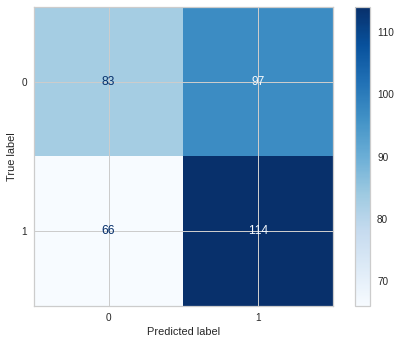

In [ ]:
cm = confusion_matrix(np.array(vecY_val).flatten(), np.array(vecY_predV).flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

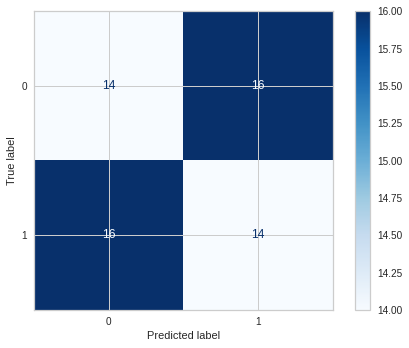

In [ ]:
cm = confusion_matrix(vecY_test, vecY_predT)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [ ]:
learning_rate   = 0.0001
opt             = keras.optimizers.Adam(learning_rate=learning_rate)
EPOCHS          = 20
number_of_folds = 60
LOSS            = tf.keras.losses.sparse_categorical_crossentropy
num_rep         = 1
vecAccV, vecY_predV, vecY_val, vecAccT, vecY_predT, vecY_test, lossValVec, lossTestVec = main(custom_VGG16(), "VGG16")

58889256/58889256 [==============================] - 0s 0us/step
Index: 0
1/1 [==============================] - 0s 25ms/step
Index: 1
1/1 [==============================] - 0s 24ms/step
Index: 2
1/1 [==============================] - 0s 24ms/step
Index: 3
1/1 [==============================] - 0s 23ms/step
Index: 4


WARNING 5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x7f9c3064adc0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 1s 661ms/step - loss: 60.4791 - accuracy: 0.5000


WARNING 5 out of the last 9 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f9c303adca0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 23ms/step
Index: 5


WARNING 6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f9cc014e3a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 228ms/step - loss: 1.8844 - accuracy: 0.6667


WARNING 6 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f9cf70e81f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 23ms/step
Index: 6
1/1 [==============================] - 0s 24ms/step
Index: 7
1/1 [==============================] - 0s 23ms/step
Index: 8
1/1 [==============================] - 0s 23ms/step
Index: 9
1/1 [==============================] - 0s 24ms/step
Index: 10
1/1 [==============================] - 0s 24ms/step
Index: 11
1/1 [==============================] - 0s 24ms/step
Index: 12
1/1 [==============================] - 0s 23ms/step
Index: 13
1/1 [==============================] - 0s 25ms/step
Index: 14
1/1 [==============================] - 0s 23ms/step
Index: 15
1/1 [==============================] - 0s 24ms/step
Index: 16
1/1 [==============================] - 0s 23ms/step
Index: 17
1/1 [==============================] - 0s 24ms/step
Index: 18
1/1 [==============================] - 0s 24ms/step
Index: 19
1/1 [==============================] - 0s 25ms/step
Index: 20
1/1 [==============================] - 0s 24ms/step
Index: 21
1/1 [=======

In [ ]:
with open('drive/MyDrive/TCC/metricas/vgg16000104.txt', 'w') as writefile:
  writefile.write(str(statistics.mean(vecAccV))+"\n")
  writefile.write(str(precision(vecY_predV, vecY_val))+"\n")
  writefile.write(str(recall(vecY_predV, vecY_val))+"\n")
  writefile.write(str(f1Score(vecY_predV, vecY_val))+"\n")
  writefile.write(str(statistics.mean(vecAccT))+"\n")
  writefile.write(str(precision(vecY_predT, vecY_test))+"\n")
  writefile.write(str(recall(vecY_predT, vecY_test))+"\n")
  writefile.write(str(f1Score(vecY_predT, vecY_test))+"\n")
with open('drive/MyDrive/TCC/metricas/vgg160001loss02.txt', 'w') as writefile:
  writefile.write(str(lossValVec)+"\n")
  writefile.write(str(lossTestVec)+"\n")


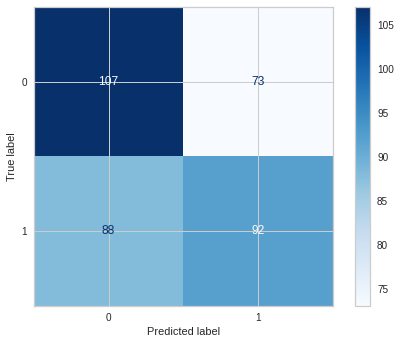

In [ ]:
cm = confusion_matrix(np.array(vecY_val).flatten(), np.array(vecY_predV).flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

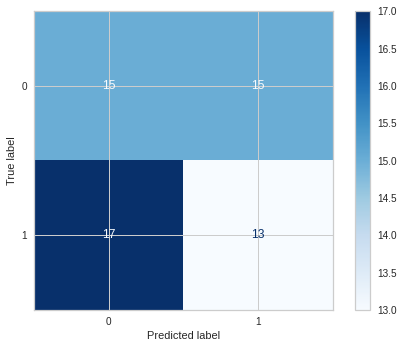

In [ ]:
cm = confusion_matrix(vecY_test, vecY_predT)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

# VGG19

In [ ]:
learning_rate   = 0.001
opt             = keras.optimizers.Adam(learning_rate=learning_rate)
EPOCHS          = 20
number_of_folds = 60
LOSS            = tf.keras.losses.sparse_categorical_crossentropy
num_rep         = 1
vecAccV, vecY_predV, vecY_val, vecAccT, vecY_predT, vecY_test, lossValVec, lossTestVec = main(custom_VGG19(), "VGG19")

80134624/80134624 [==============================] - 1s 0us/step
Index: 0
1/1 [==============================] - 0s 24ms/step
Index: 1
1/1 [==============================] - 0s 25ms/step
Index: 2
1/1 [==============================] - 0s 26ms/step
Index: 3
1/1 [==============================] - 0s 26ms/step
Index: 4
1/1 [==============================] - 0s 25ms/step
Index: 5
1/1 [==============================] - 0s 25ms/step
Index: 6
1/1 [==============================] - 0s 25ms/step
Index: 7
1/1 [==============================] - 0s 27ms/step
Index: 8
1/1 [==============================] - 0s 27ms/step
Index: 9
1/1 [==============================] - 0s 27ms/step
Index: 10
1/1 [==============================] - 0s 29ms/step
Index: 11
1/1 [==============================] - 0s 28ms/step
Index: 12
1/1 [==============================] - 0s 28ms/step
Index: 13
1/1 [==============================] - 0s 27ms/step
Index: 14
1/1 [==============================] - 0s 28ms/step
Index: 15
1/1 [

In [ ]:
with open('drive/MyDrive/TCC/metricas/vgg1900104.txt', 'w') as writefile:
  writefile.write(str(statistics.mean(vecAccV))+"\n")
  writefile.write(str(precision(vecY_predV, vecY_val))+"\n")
  writefile.write(str(recall(vecY_predV, vecY_val))+"\n")
  writefile.write(str(f1Score(vecY_predV, vecY_val))+"\n")
  writefile.write(str(statistics.mean(vecAccT))+"\n")
  writefile.write(str(precision(vecY_predT, vecY_test))+"\n")
  writefile.write(str(recall(vecY_predT, vecY_test))+"\n")
  writefile.write(str(f1Score(vecY_predT, vecY_test))+"\n")
with open('drive/MyDrive/TCC/metricas/vgg19001loss02.txt', 'w') as writefile:
  writefile.write(str(lossValVec)+"\n")
  writefile.write(str(lossTestVec)+"\n")


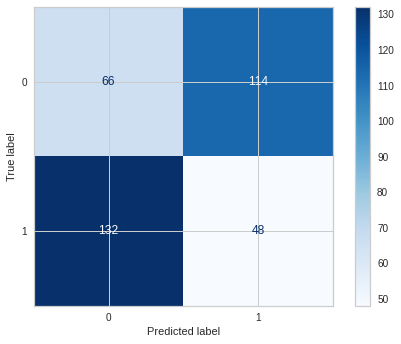

In [ ]:
cm = confusion_matrix(np.array(vecY_val).flatten(), np.array(vecY_predV).flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

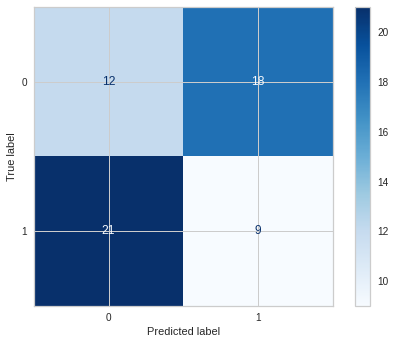

In [ ]:
cm = confusion_matrix(vecY_test, vecY_predT)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [ ]:
learning_rate   = 0.0001
opt             = keras.optimizers.Adam(learning_rate=learning_rate)
EPOCHS          = 20
number_of_folds = 60
LOSS            = tf.keras.losses.sparse_categorical_crossentropy
num_rep         = 1
vecAccV, vecY_predV, vecY_val, vecAccT, vecY_predT, vecY_test, lossValVec, lossTestVec = main(custom_VGG19(), "VGG19")

80134624/80134624 [==============================] - 1s 0us/step
Index: 0
1/1 [==============================] - 0s 23ms/step
Index: 1
1/1 [==============================] - 0s 22ms/step
Index: 2
1/1 [==============================] - 0s 23ms/step
Index: 3
1/1 [==============================] - 0s 23ms/step
Index: 4


WARNING 5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x7f67e36a1040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 473ms/step - loss: 0.7009 - accuracy: 0.3333


WARNING 5 out of the last 9 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f67d02405e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 21ms/step
Index: 5


WARNING 6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f67d03c1ee0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 244ms/step - loss: 0.6934 - accuracy: 0.5000


WARNING 6 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f66dc024c10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 21ms/step
Index: 6
1/1 [==============================] - 0s 22ms/step
Index: 7
1/1 [==============================] - 0s 23ms/step
Index: 8
1/1 [==============================] - 0s 23ms/step
Index: 9
1/1 [==============================] - 0s 23ms/step
Index: 10
1/1 [==============================] - 0s 23ms/step
Index: 11
1/1 [==============================] - 0s 22ms/step
Index: 12
1/1 [==============================] - 0s 23ms/step
Index: 13
1/1 [==============================] - 0s 23ms/step
Index: 14
1/1 [==============================] - 0s 22ms/step
Index: 15
1/1 [==============================] - 0s 22ms/step
Index: 16
1/1 [==============================] - 0s 23ms/step
Index: 17
1/1 [==============================] - 0s 22ms/step
Index: 18
1/1 [==============================] - 0s 22ms/step
Index: 19
1/1 [==============================] - 0s 22ms/step
Index: 20
1/1 [==============================] - 0s 22ms/step
Index: 21
1/1 [=======

In [ ]:
with open('drive/MyDrive/TCC/metricas/vgg19000104.txt', 'w') as writefile:
  writefile.write(str(statistics.mean(vecAccV))+"\n")
  writefile.write(str(precision(vecY_predV, vecY_val))+"\n")
  writefile.write(str(recall(vecY_predV, vecY_val))+"\n")
  writefile.write(str(f1Score(vecY_predV, vecY_val))+"\n")
  writefile.write(str(statistics.mean(vecAccT))+"\n")
  writefile.write(str(precision(vecY_predT, vecY_test))+"\n")
  writefile.write(str(recall(vecY_predT, vecY_test))+"\n")
  writefile.write(str(f1Score(vecY_predT, vecY_test))+"\n")
with open('drive/MyDrive/TCC/metricas/vgg190001loss02.txt', 'w') as writefile:
  writefile.write(str(lossValVec)+"\n")
  writefile.write(str(lossTestVec)+"\n")

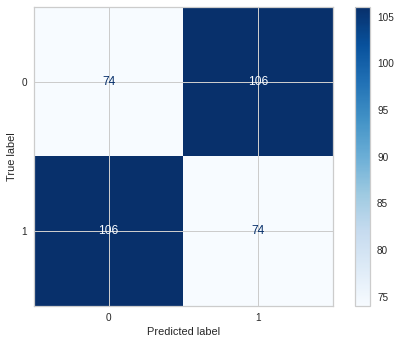

In [ ]:
cm = confusion_matrix(np.array(vecY_val).flatten(), np.array(vecY_predV).flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

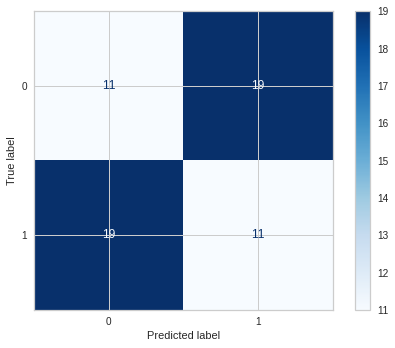

In [ ]:
cm = confusion_matrix(vecY_test, vecY_predT)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

# InceptionV3

In [ ]:
learning_rate   = 0.001
opt             = keras.optimizers.Adam(learning_rate=learning_rate)
EPOCHS          = 20
number_of_folds = 60
LOSS            = tf.keras.losses.sparse_categorical_crossentropy
num_rep         = 1
vecAccV, vecY_predV, vecY_val, vecAccT, vecY_predT, vecY_test, lossValVec, lossTestVec = main(custom_InceptionV3(), "InceptionV3")

87910968/87910968 [==============================] - 5s 0us/step
Index: 0
1/1 [==============================] - 0s 34ms/step
Index: 1
1/1 [==============================] - 0s 33ms/step
Index: 2
1/1 [==============================] - 0s 33ms/step
Index: 3
1/1 [==============================] - 0s 32ms/step
Index: 4


WARNING 5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x7f5505b89d30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 2s 2s/step - loss: 1.7287 - accuracy: 0.3333


WARNING 5 out of the last 9 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f5505be0310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 33ms/step
Index: 5


WARNING 6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f5506506c10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 1s 1s/step - loss: 1.8453 - accuracy: 0.6667


WARNING 6 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f5505af2a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 33ms/step
Index: 6
1/1 [==============================] - 0s 32ms/step
Index: 7
1/1 [==============================] - 0s 34ms/step
Index: 8
1/1 [==============================] - 0s 34ms/step
Index: 9
1/1 [==============================] - 0s 34ms/step
Index: 10
1/1 [==============================] - 0s 32ms/step
Index: 11
1/1 [==============================] - 0s 32ms/step
Index: 12
1/1 [==============================] - 0s 33ms/step
Index: 13
1/1 [==============================] - 0s 37ms/step
Index: 14
1/1 [==============================] - 0s 33ms/step
Index: 15
1/1 [==============================] - 0s 32ms/step
Index: 16
1/1 [==============================] - 0s 32ms/step
Index: 17
1/1 [==============================] - 0s 33ms/step
Index: 18
1/1 [==============================] - 0s 32ms/step
Index: 19
1/1 [==============================] - 0s 33ms/step
Index: 20
1/1 [==============================] - 0s 33ms/step
Index: 21
1/1 [=======

In [ ]:
with open('drive/MyDrive/TCC/metricas/inception00104.txt', 'w') as writefile:
  writefile.write(str(statistics.mean(vecAccV))+"\n")
  writefile.write(str(precision(vecY_predV, vecY_val))+"\n")
  writefile.write(str(recall(vecY_predV, vecY_val))+"\n")
  writefile.write(str(f1Score(vecY_predV, vecY_val))+"\n")
  writefile.write(str(statistics.mean(vecAccT))+"\n")
  writefile.write(str(precision(vecY_predT, vecY_test))+"\n")
  writefile.write(str(recall(vecY_predT, vecY_test))+"\n")
  writefile.write(str(f1Score(vecY_predT, vecY_test))+"\n")
with open('drive/MyDrive/TCC/metricas/inception001loss02.txt', 'w') as writefile:
  writefile.write(str(lossValVec)+"\n")
  writefile.write(str(lossTestVec)+"\n")

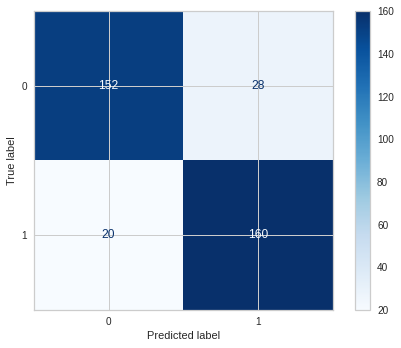

In [ ]:
cm = confusion_matrix(np.array(vecY_val).flatten(), np.array(vecY_predV).flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

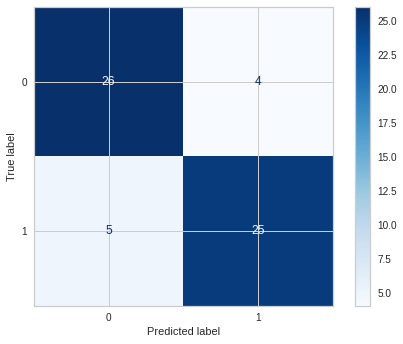

In [ ]:
cm = confusion_matrix(vecY_test, vecY_predT)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [ ]:
learning_rate   = 0.0001
opt             = keras.optimizers.Adam(learning_rate=learning_rate)
EPOCHS          = 20
number_of_folds = 60
LOSS            = tf.keras.losses.sparse_categorical_crossentropy
num_rep         = 1
vecAccV, vecY_predV, vecY_val, vecAccT, vecY_predT, vecY_test, lossValVec, lossTestVec = main(custom_InceptionV3(), "InceptionV3")

Index: 0
1/1 [==============================] - 0s 33ms/step
Index: 1
1/1 [==============================] - 0s 34ms/step
Index: 2
1/1 [==============================] - 0s 35ms/step
Index: 3
1/1 [==============================] - 0s 35ms/step
Index: 4
1/1 [==============================] - 0s 34ms/step
Index: 5
1/1 [==============================] - 0s 35ms/step
Index: 6
1/1 [==============================] - 0s 35ms/step
Index: 7
1/1 [==============================] - 0s 39ms/step
Index: 8
1/1 [==============================] - 0s 41ms/step
Index: 9
1/1 [==============================] - 0s 37ms/step
Index: 10
1/1 [==============================] - 0s 36ms/step
Index: 11
1/1 [==============================] - 0s 37ms/step
Index: 12
1/1 [==============================] - 0s 37ms/step
Index: 13
1/1 [==============================] - 0s 36ms/step
Index: 14
1/1 [==============================] - 0s 37ms/step
Index: 15
1/1 [==============================] - 0s 36ms/step
Index: 16
1/1 [===

In [ ]:
with open('drive/MyDrive/TCC/metricas/inception000104.txt', 'w') as writefile:
  writefile.write(str(statistics.mean(vecAccV))+"\n")
  writefile.write(str(precision(vecY_predV, vecY_val))+"\n")
  writefile.write(str(recall(vecY_predV, vecY_val))+"\n")
  writefile.write(str(f1Score(vecY_predV, vecY_val))+"\n")
  writefile.write(str(statistics.mean(vecAccT))+"\n")
  writefile.write(str(precision(vecY_predT, vecY_test))+"\n")
  writefile.write(str(recall(vecY_predT, vecY_test))+"\n")
  writefile.write(str(f1Score(vecY_predT, vecY_test))+"\n")
with open('drive/MyDrive/TCC/metricas/inception0001loss02.txt', 'w') as writefile:
  writefile.write(str(lossValVec)+"\n")
  writefile.write(str(lossTestVec)+"\n")

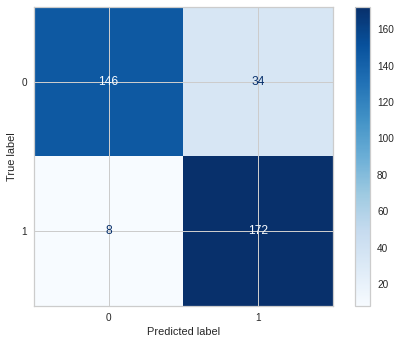

In [ ]:
cm = confusion_matrix(np.array(vecY_val).flatten(), np.array(vecY_predV).flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

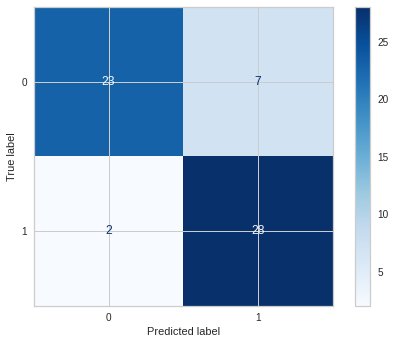

In [ ]:
cm = confusion_matrix(vecY_test, vecY_predT)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

# ResNet

In [ ]:
learning_rate   = 0.001
opt             = keras.optimizers.Adam(learning_rate=learning_rate)
EPOCHS          = 20
number_of_folds = 60
LOSS            = tf.keras.losses.sparse_categorical_crossentropy
num_rep         = 1
vecAccV, vecY_predV, vecY_val, vecAccT, vecY_predT, vecY_test, lossValVec, lossTestVec = main(custom_ResNet50V2(), "ResNet50V2")

94668760/94668760 [==============================] - 0s 0us/step
Index: 0
1/1 [==============================] - 0s 36ms/step
Index: 1
1/1 [==============================] - 0s 31ms/step
Index: 2
1/1 [==============================] - 0s 30ms/step
Index: 3
1/1 [==============================] - 0s 29ms/step
Index: 4
1/1 [==============================] - 0s 30ms/step
Index: 5
1/1 [==============================] - 0s 29ms/step
Index: 6
1/1 [==============================] - 0s 29ms/step
Index: 7
1/1 [==============================] - 0s 31ms/step
Index: 8
1/1 [==============================] - 0s 29ms/step
Index: 9
1/1 [==============================] - 0s 29ms/step
Index: 10
1/1 [==============================] - 0s 29ms/step
Index: 11
1/1 [==============================] - 0s 29ms/step
Index: 12
1/1 [==============================] - 0s 30ms/step
Index: 13
1/1 [==============================] - 0s 30ms/step
Index: 14
1/1 [==============================] - 0s 38ms/step
Index: 15
1/1 [

In [ ]:
with open('drive/MyDrive/TCC/metricas/resNet00104.txt', 'w') as writefile:
  writefile.write(str(statistics.mean(vecAccV))+"\n")
  writefile.write(str(precision(vecY_predV, vecY_val))+"\n")
  writefile.write(str(recall(vecY_predV, vecY_val))+"\n")
  writefile.write(str(f1Score(vecY_predV, vecY_val))+"\n")
  writefile.write(str(statistics.mean(vecAccT))+"\n")
  writefile.write(str(precision(vecY_predT, vecY_test))+"\n")
  writefile.write(str(recall(vecY_predT, vecY_test))+"\n")
  writefile.write(str(f1Score(vecY_predT, vecY_test))+"\n")
with open('drive/MyDrive/TCC/metricas/resNet001loss02.txt', 'w') as writefile:
  writefile.write(str(lossValVec)+"\n")
  writefile.write(str(lossTestVec)+"\n")

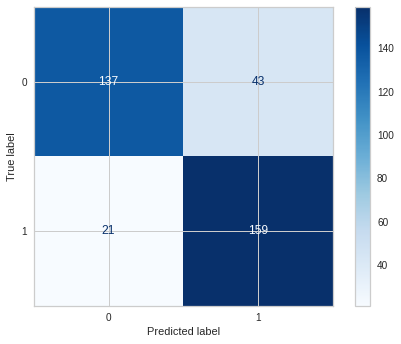

In [ ]:
cm = confusion_matrix(np.array(vecY_val).flatten(), np.array(vecY_predV).flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

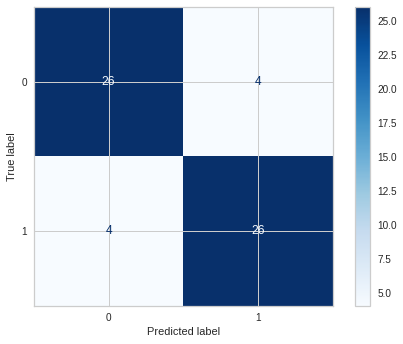

In [ ]:
cm = confusion_matrix(vecY_test, vecY_predT)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [ ]:
learning_rate   = 0.0001
opt             = keras.optimizers.Adam(learning_rate=learning_rate)
EPOCHS          = 20
number_of_folds = 60
LOSS            = tf.keras.losses.sparse_categorical_crossentropy
num_rep         = 1
vecAccV, vecY_predV, vecY_val, vecAccT, vecY_predT, vecY_test, lossValVec, lossTestVec = main(custom_ResNet50V2(), "ResNet50V2")

Index: 0
1/1 [==============================] - 0s 28ms/step
Index: 1
1/1 [==============================] - 0s 29ms/step
Index: 2
1/1 [==============================] - 0s 28ms/step
Index: 3
1/1 [==============================] - 0s 28ms/step
Index: 4
1/1 [==============================] - 0s 29ms/step
Index: 5
1/1 [==============================] - 0s 29ms/step
Index: 6
1/1 [==============================] - 0s 28ms/step
Index: 7
1/1 [==============================] - 0s 31ms/step
Index: 8
1/1 [==============================] - 0s 30ms/step
Index: 9
1/1 [==============================] - 0s 29ms/step
Index: 10
1/1 [==============================] - 0s 38ms/step
Index: 11
1/1 [==============================] - 0s 35ms/step
Index: 12
1/1 [==============================] - 0s 31ms/step
Index: 13
1/1 [==============================] - 0s 30ms/step
Index: 14
1/1 [==============================] - 0s 30ms/step
Index: 15
1/1 [==============================] - 0s 30ms/step
Index: 16
1/1 [===

In [ ]:
with open('drive/MyDrive/TCC/metricas/resNet000104.txt', 'w') as writefile:
  writefile.write(str(statistics.mean(vecAccV))+"\n")
  writefile.write(str(precision(vecY_predV, vecY_val))+"\n")
  writefile.write(str(recall(vecY_predV, vecY_val))+"\n")
  writefile.write(str(f1Score(vecY_predV, vecY_val))+"\n")
  writefile.write(str(statistics.mean(vecAccT))+"\n")
  writefile.write(str(precision(vecY_predT, vecY_test))+"\n")
  writefile.write(str(recall(vecY_predT, vecY_test))+"\n")
  writefile.write(str(f1Score(vecY_predT, vecY_test))+"\n")
with open('drive/MyDrive/TCC/metricas/resNet0001loss02.txt', 'w') as writefile:
  writefile.write(str(lossValVec)+"\n")
  writefile.write(str(lossTestVec)+"\n")

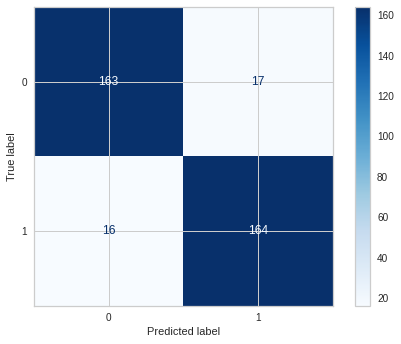

In [ ]:
cm = confusion_matrix(np.array(vecY_val).flatten(), np.array(vecY_predV).flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

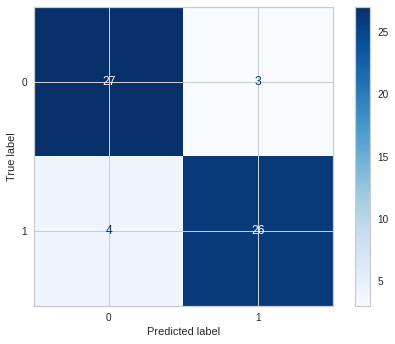

In [ ]:
cm = confusion_matrix(vecY_test, vecY_predT)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

# Estatisticas

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import norm
# import statistics

# # Calculating mean and standard deviation
# for i in resultados:
#   mean = statistics.mean(resultados[i])
#   sd = statistics.stdev(resultados[i])

#   plt.plot(norm.pdf(resultados[i], mean, sd))
#   plt.show()

In [ ]:
# sns.displot(data=resultados['Precision'], kind="kde")

In [ ]:
# resultados

In [ ]:
# resultados.describe()

Verificar pra fazer algo customizado e alterar o classiicador por meio de um laço, fica bala

Antes tava fazendo 50% treino e 50% teste, por isso o 0.333333...

> Mount e Defines

>  Funções que abrem a imagem

> *   openImgs()
*   join()
*   joi_open_file()
*   def VGG16(), InceptionV3() e ResNet50V2()
*   chamadas das redes usando o Leave-One-Out
*   chamada dos summary() das redes

> Problemas não resolvidos
* Fazer uma descrição de cada rede



> Problemas resolvidos

# Alguns tests

In [ ]:
file = open('drive/MyDrive/TCC/metricas/vgg1600103.txt', 'r')

In [ ]:
directory = 'drive/MyDrive/TCC/metricas/'
for filename in os.scandir(directory):
  print(filename)

In [ ]:
def mtrcDF(archName, tamanho):
  vec = []
  auxv = [[], [], [], [], [], [], [], []]
  for i in range(tamanho):
    file = open('drive/MyDrive/TCC/metricas/'+archName+str(i+1)+'.txt', 'r')
    for item in file:
      vec.append(float(item.replace('\n','')))
  i = 0
  for elem in vec:
    auxv[i%8].append(elem)
    i += 1

  dataframeVal = pd.DataFrame({'Acuracia': auxv[0], 'Precision': auxv[1], 'Recall': auxv[2], 'F1Score': auxv[3]})
  dataframeTst = pd.DataFrame({'Acuracia': auxv[4], 'Precision': auxv[5], 'Recall': auxv[6], 'F1Score': auxv[7]})
  return dataframeVal, dataframeTst

In [ ]:
dataframeV, dataframeT = mtrcDF('inception00010', 3)

In [ ]:
dataframeV

Acuracia  Precision    Recall   F1Score
0  0.869444   0.855556  0.880000  0.867606
1  0.872222   0.888889  0.860215  0.874317
2  0.855556   0.922222  0.813725  0.864583

In [ ]:
dataframeV.describe()

Acuracia  Precision    Recall   F1Score
count  3.000000   3.000000  3.000000  3.000000
mean   0.865741   0.888889  0.851314  0.868835
std    0.008929   0.033333  0.034022  0.004982
min    0.855556   0.855556  0.813725  0.864583
25%    0.862500   0.872222  0.836970  0.866094
50%    0.869444   0.888889  0.860215  0.867606
75%    0.870833   0.905556  0.870108  0.870961
max    0.872222   0.922222  0.880000  0.874317

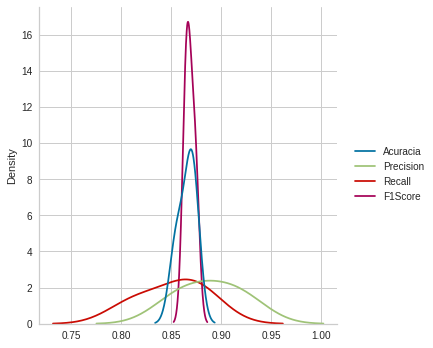

In [ ]:
sns.displot(dataframeV, kind="kde")

In [ ]:
def mtrcDFLoss(archName, tamanho):
  vec = []
  auxv = [[], [], [], []]
  k  = 0
  for i in range(tamanho):
    file = open('drive/MyDrive/TCC/metricas/'+archName+'loss0'+str(i+1)+'.txt', 'r')
    for elem in file:
      vec.append(elem)

  lis = []
  # li = list(elem.split(","))
  for item in vec:
    if(item.count('[')):
      lis.append(item.replace('[',''))
    if(item.count(']')):
      lis.append(item.replace(']',''))
    if(item.count('\n')):
      lis.append(item.replace('\n',''))
    # else:
    #   lis.append(item)


  print(lis)
    # print(float(item.replace('[','')))


In [ ]:
mtrcDFLoss("inception0001", 2)

['63.50340270996094, 1826.6287841796875, 150.43772888183594, 0.22856158018112183, 3.627251386642456, 16390.09375, 2.901639223098755, 1.637499451637268, 3.3078019618988037, 0.22422312200069427, 1.3495732545852661, 1.3289703130722046, 20.418386459350586, 0.0, 0.08775895833969116, 4.406666278839111, 4.800273418426514, 0.0, 1.1920925402364446e-07, 0.0, 0.18843413889408112, 0.0008593262755312026, 0.0, 8.614970207214355, 0.0, 9.219447135925293, 0.0, 1.6425185203552246, 1.5878816843032837, 12.605838775634766, 2.631955146789551, 3.5962698459625244, 4.768367887209024e-07, 8.68218376126606e-06, 6.216452121734619, 0.0, 28.409812927246094, 0.0, 1.3680750131607056, 0.0, 1.0996383428573608, 0.0, 8.344629236489709e-07, 0.0033838602248579264, 1.2854238775616977e-05, 0.0, 0.0, 0.0, 0.0, 2.409893035888672, 0.0, 0.8470557332038879, 0.0, 0.0, 0.0, 3.530949831008911, 0.0, 0.0, 0.0, 0.0]\n', '[63.50340270996094, 1826.6287841796875, 150.43772888183594, 0.22856158018112183, 3.627251386642456, 16390.09375, 2.9

In [ ]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.333
# session = InteractiveSession(config=config)

# model code as usual down here

In [ ]:
# from keras.optimizers import Adam
# model = custom_VGG16()
# opt = Adam(learning_rate=0.01)
# model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
# name = "VGG16"
# checkpoint_path = 'drive/MyDrive/TCC/checkpoints/'
# checkpoint_name = name+'peso_TESTE.tf'
# checkpoint = ModelCheckpoint(checkpoint_path+checkpoint_name, monitor='accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
# early = EarlyStopping(monitor='accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [ ]:
# #faz um teste com a base de dados inteira pra verificar
# #se o treinamento foi feito corretamente
# def test_split(X, y, model, checkpoint):
#   # LR = 0.01
#   model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

#   X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size = .2)

#   loss, acc = model.evaluate(X1_test, y1_test)
#   print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))
#   y1_pred = model.predict(X1_test)
#   y1_pred = np.argmax(y1_pred, axis=1)
#   print(y1_test)
#   print(y1_pred)

#   moswl = model.load_weights(checkpoint_path+checkpoint_name)
#   loss, acc = model.evaluate(X1_test, y1_test)
#   print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
#   y1_pred = model.predict(X1_test)
#   y1_pred = np.argmax(y1_pred, axis=1)
#   print(y1_test)
#   print(y1_pred)

In [ ]:
# X.shape

TESTE COM VGG16 - LOA - SEM AUG

In [ ]:
# bestAcc = 0
# metric  = [[],[],[],[],[]]
# vecAcc  = []
# KF      = KFold(n_splits = 60, shuffle = True)

# for j, (train_index, test_index) in enumerate(KF.split(X)):
#   print(f"Iteration {j}: ")
#   print(f"Fold {j}: ")

#   LR = 0.01
#   model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

#   X_train, X_test = X[train_index], X[test_index]
#   y_train, y_test = y[train_index], y[test_index]

#   history = model.fit(X_train, y_train, steps_per_epoch = 10, validation_split = 0.1, validation_steps = 1, epochs = 10, callbacks=[checkpoint, early], verbose = 0)

#   y_pred = model.predict(X_test)
#   y_pred = np.argmax(y_pred, axis=1)

#   loss, acc = model.evaluate(X_test, y_test)

#   metrics(metric, history, y_test, y_pred)

#   vecAcc.append(acc)

# print(metric)

# from keras.models import load_model
# test_split(X, y, custom_VGG16(), checkpoint)


In [ ]:
# from keras.optimizers import Adam
# model = custom_VGG19()
# opt = Adam(learning_rate=0.01)
# model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
# name = "VGG19"
# checkpoint_path = 'drive/MyDrive/TCC/checkpoints/'
# checkpoint_name = name+'peso_TESTE19.tf'
# checkpoint = ModelCheckpoint(checkpoint_path+checkpoint_name, monitor='accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
# early = EarlyStopping(monitor='accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

# bestAcc = 0
# metric  = [[],[],[],[],[]]
# vecAcc  = []
# KF      = KFold(n_splits = 60, shuffle = True)

# for j, (train_index, test_index) in enumerate(KF.split(X)):
#   print(f"Iteration {j}: ")
#   print(f"Fold {j}: ")

#   LR = 0.01
#   model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

#   X_train, X_test = X[train_index], X[test_index]
#   y_train, y_test = y[train_index], y[test_index]

#   history = model.fit(X_train, y_train, steps_per_epoch = 10, validation_split = 0.1, validation_steps = 1, epochs = 10, callbacks=[checkpoint, early], verbose = 0)

#   y_pred = model.predict(X_test)
#   y_pred = np.argmax(y_pred, axis=1)

#   loss, acc = model.evaluate(X_test, y_test)

#   metrics(metric, history, y_test, y_pred)

#   vecAcc.append(acc)

# print(metric)

# from keras.models import load_model
# test_split(X, y, custom_VGG19(), checkpoint)

In [ ]:
# from keras.optimizers import Adam
# model = custom_InceptionV3()
# opt = Adam(learning_rate=0.01)
# model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
# name = "InceptionV3"
# checkpoint_path = 'drive/MyDrive/TCC/checkpoints/'
# checkpoint_name = name+'peso_TESTEInc.tf'
# checkpoint = ModelCheckpoint(checkpoint_path+checkpoint_name, monitor='accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
# early = EarlyStopping(monitor='accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

# bestAcc = 0
# metric  = [[],[],[],[],[]]
# vecAcc  = []
# KF      = KFold(n_splits = 60, shuffle = True)

# for j, (train_index, test_index) in enumerate(KF.split(X)):
#   print(f"Iteration {j}: ")
#   print(f"Fold {j}: ")

#   LR = 0.01
#   model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

#   X_train, X_test = X[train_index], X[test_index]
#   y_train, y_test = y[train_index], y[test_index]

#   history = model.fit(X_train, y_train, steps_per_epoch = 10, validation_split = 0.1, validation_steps = 1, epochs = 10, callbacks=[checkpoint, early], verbose = 0)

#   y_pred = model.predict(X_test)
#   y_pred = np.argmax(y_pred, axis=1)

#   loss, acc = model.evaluate(X_test, y_test)

#   metrics(metric, history, y_test, y_pred)

#   vecAcc.append(acc)

# print(metric)

# from keras.models import load_model
# test_split(X, y, custom_InceptionV3(), checkpoint)

In [ ]:
# from keras.optimizers import Adam
# model = custom_ResNet50V2()
# opt = Adam(learning_rate=0.01)
# model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
# name = "ResNet50V2"
# checkpoint_path = 'drive/MyDrive/TCC/checkpoints/'
# checkpoint_name = name+'peso_TESTERes.tf'
# checkpoint = ModelCheckpoint(checkpoint_path+checkpoint_name, monitor='accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
# early = EarlyStopping(monitor='accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

# bestAcc = 0
# metric  = [[],[],[],[],[]]
# vecAcc  = []
# KF      = KFold(n_splits = 60, shuffle = True)

# for j, (train_index, test_index) in enumerate(KF.split(X)):
#   print(f"Iteration {j}: ")
#   print(f"Fold {j}: ")

#   LR = 0.01
#   model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

#   X_train, X_test = X[train_index], X[test_index]
#   y_train, y_test = y[train_index], y[test_index]

#   history = model.fit(X_train, y_train, steps_per_epoch = 10, validation_split = 0.1, validation_steps = 1, epochs = 10, callbacks=[checkpoint, early], verbose = 0)

#   y_pred = model.predict(X_test)
#   y_pred = np.argmax(y_pred, axis=1)

#   loss, acc = model.evaluate(X_test, y_test)

#   metrics(metric, history, y_test, y_pred)

#   vecAcc.append(acc)

# print(metric)

# from keras.models import load_model
# test_split(X, y, custom_ResNet50V2(), checkpoint)

In [ ]:
# Sensibility = metric[0][1:]
# Specificity = metric[1][1:]
# Precision   = metric[2][1:]
# Recall      = metric[3][1:]
# F1Score     = metric[4][1:]
# resultados = pd.DataFrame({'Accuracy': vecAcc, 'Sensibility': Sensibility, 'Specificity': Specificity,
#                           'Precision': Precision, 'Recall': Recall, 'F1Score': F1Score})
# resultados.describe()

In [ ]:
# from psutil import *

In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         167G   25G  143G  15% /
tmpfs            64M     0   64M   0% /dev
shm              41G     0   41G   0% /dev/shm
/dev/root       2.0G  1.1G  841M  58% /usr/sbin/docker-init
/dev/sda1       174G   51G  123G  30% /opt/bin/.nvidia
tmpfs            42G   36K   42G   1% /var/colab
tmpfs            42G     0   42G   0% /proc/acpi
tmpfs            42G     0   42G   0% /proc/scsi
tmpfs            42G     0   42G   0% /sys/firmware
drive            15G  4.9G   11G  33% /content/drive


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 7
microcode	: 0xffffffff
cpu MHz		: 2200.194
cache size	: 39424 KB
physical id	: 0
siblings	: 12
core id		: 0
cpu cores	: 6
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp ibrs_enhanced fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat avx512_vnni md_clear arch_capabilities
bugs		: spectre_v1 spectre_v2 spec_store_bypass mds swapg

In [ ]:
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-0a2b6813-36eb-9091-b7eb-d6dd55d81979)


In [ ]:
cpu_count()

In [ ]:
!cat /proc/meminfo

In [ ]:
virtual_memory()

# Resultados


In [ ]:
def mtrcDF(archName, tamanho):
  vec = []
  auxv = [[], [], [], [], [], [], [], []]
  for i in range(tamanho):
    file = open('drive/MyDrive/TCC/metricas/'+archName+str(i+1)+'.txt', 'r')
    for item in file:
      vec.append(float(item.replace('\n','')))
  i = 0
  for elem in vec:
    auxv[i%8].append(elem)
    i += 1

  dataframeVal = pd.DataFrame({'Acuracia': auxv[0], 'Especificidade': auxv[1], 'Sensibilidade ': auxv[2], 'F1Score': auxv[3]})
  dataframeTst = pd.DataFrame({'Acuracia': auxv[4], 'Especificidade': auxv[5], 'Sensibilidade ': auxv[6], 'F1Score': auxv[7]})
  return dataframeVal, dataframeTst

# VGG16 resultados



In [ ]:
dataframeV, dataframeT = mtrcDF('vgg160010', 4)

In [ ]:
vec = [0.4,	0.4,	0.5,	0.46666667]
dataframeT.insert(loc = 4, column = 'Precisão', value = vec)

In [ ]:
dataframeT.describe()

Acuracia  Especificidade  Sensibilidade    F1Score  Precisão
count  4.000000        4.000000        4.000000  4.000000  4.000000
mean   0.429167        0.408333        0.419589  0.412830  0.441667
std    0.043833        0.087665        0.050733  0.068209  0.050000
min    0.366667        0.333333        0.357143  0.344828  0.400000
25%    0.416667        0.333333        0.389286  0.358934  0.400000
50%    0.441667        0.400000        0.427273  0.415152  0.433333
75%    0.454167        0.475000        0.457576  0.469048  0.475000
max    0.466667        0.500000        0.466667  0.476190  0.500000

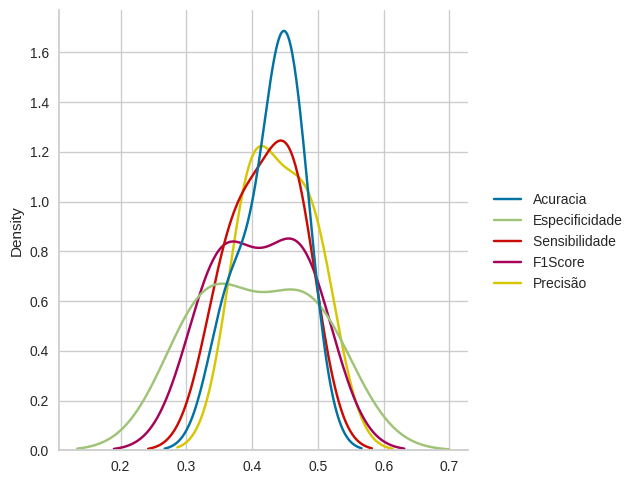

In [ ]:
sns.displot(dataframeT, kind="kde")

In [ ]:
dataframeV, dataframeT = mtrcDF('vgg1600010', 4)

In [ ]:
vec = [0.4666666667,	0.4,	0.3333333333,	0.4333333333]
dataframeT.insert(loc = 4, column = 'Precisão', value = vec)

In [ ]:
dataframeT.describe()

Acuracia  Especificidade  Sensibilidade    F1Score  Precisão
count  4.000000        4.000000        4.000000  4.000000  4.000000
mean   0.404167        0.383333        0.398500  0.389677  0.408333
std    0.047871        0.079349        0.054599  0.063871  0.056928
min    0.350000        0.300000        0.333333  0.315790  0.333333
25%    0.387500        0.325000        0.371795  0.346805  0.383333
50%    0.400000        0.383333        0.398190  0.397321  0.416667
75%    0.416667        0.441667        0.424895  0.440194  0.441667
max    0.466667        0.466667        0.464286  0.448276  0.466667

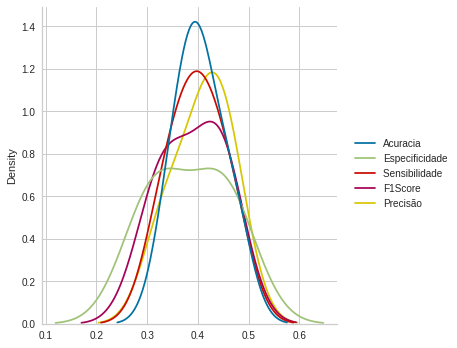

In [ ]:
sns.displot(dataframeT, kind="kde")

# VGG19 resultados


In [ ]:
dataframeV, dataframeT = mtrcDF('vgg190010', 4)

In [ ]:
vec = [0.3333333333,	0.73333333333,	0.43333333333,	0.4]
dataframeT.insert(loc = 4, column = 'Precisão', value = vec)

In [ ]:
dataframeT.describe()

Acuracia  Especificidade  Sensibilidade    F1Score  Precisão
count  4.000000        4.000000        4.000000  4.000000  4.000000
mean   0.458333        0.441667        0.446759  0.443548  0.475000
std    0.206604        0.239405        0.202913  0.220895  0.177169
min    0.333333        0.300000        0.333333  0.315790  0.333333
25%    0.345833        0.325000        0.333333  0.328947  0.383333
50%    0.366667        0.333333        0.351852  0.342105  0.416667
75%    0.479167        0.450000        0.465278  0.456706  0.508333
max    0.766667        0.800000        0.750000  0.774194  0.733333

(0.0, 1.0)

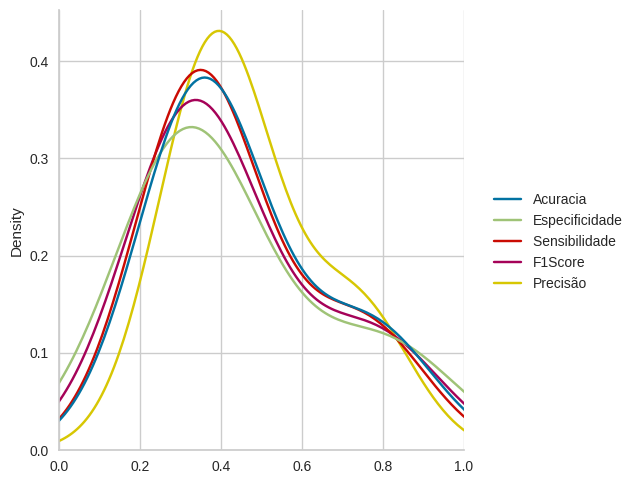

In [ ]:
sns.displot(dataframeT, kind="kde")
plt.xlim(0,1)

In [ ]:
dataframeV, dataframeT = mtrcDF('vgg1900010', 4)

In [ ]:
vec = [0.8666667,	0.5,	0.3666666667,	0.2666666667]
dataframeT.insert(loc = 4, column = 'Precisão', value = vec)

In [ ]:
dataframeT.describe()

Acuracia  Especificidade  Sensibilidade    F1Score  Precisão
count  4.000000        4.000000        4.000000  4.000000  4.000000
mean   0.466667        0.433333        0.470960  0.450525  0.500000
std    0.238436        0.224433        0.256771  0.239455  0.262467
min    0.283333        0.300000        0.290323  0.295082  0.266667
25%    0.345833        0.300000        0.347581  0.323770  0.341667
50%    0.383333        0.333333        0.370833  0.350000  0.433333
75%    0.504167        0.466667        0.494213  0.476754  0.591667
max    0.816667        0.766667        0.851852  0.807018  0.866667

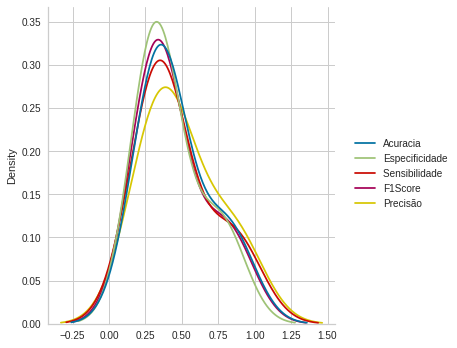

In [ ]:
sns.displot(dataframeT, kind="kde")

# Inception V3 resultados


In [ ]:
dataframeV, dataframeT = mtrcDF('inception0010', 4)

In [ ]:
vec = [0.866666667,	0.9,	0.8666666667,	0.7666666667]
dataframeT.insert(loc = 4, column = 'Precisão', value = vec)

In [ ]:
dataframeT.describe()

Acuracia  Especificidade  Sensibilidade    F1Score  Precisão
count  4.000000        4.000000        4.000000  4.000000  4.000000
mean   0.837500        0.841667        0.837331  0.837382  0.850000
std    0.034359        0.073912        0.044977  0.039351  0.057735
min    0.800000        0.733333        0.794118  0.785714  0.766667
25%    0.825000        0.833333        0.807904  0.825461  0.841667
50%    0.833333        0.866667        0.829327  0.841230  0.866667
75%    0.845833        0.875000        0.858753  0.853151  0.875000
max    0.883333        0.900000        0.896552  0.881356  0.900000

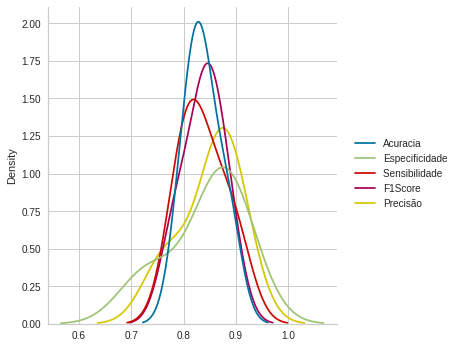

In [ ]:
sns.displot(dataframeT, kind="kde")

In [ ]:
dataframeV, dataframeT = mtrcDF('inception00010', 4)

In [ ]:
vec = [0.83333333,	0.9,	0.8666666667,	0.7666666667]
dataframeT.insert(loc = 4, column = 'Precisão', value = vec)

In [ ]:
dataframeT.describe()

Acuracia  Especificidade  Sensibilidade    F1Score  Precisão
count  4.000000        4.000000        4.000000  4.000000  4.000000
mean   0.825000        0.858333        0.812544  0.829600  0.841667
std    0.021517        0.095743        0.060196  0.025476  0.056928
min    0.800000        0.733333        0.736842  0.800000  0.766667
25%    0.812500        0.808333        0.784211  0.817647  0.816667
50%    0.825000        0.883333        0.816667  0.828431  0.850000
75%    0.837500        0.933333        0.845000  0.840385  0.875000
max    0.850000        0.933333        0.880000  0.861538  0.900000

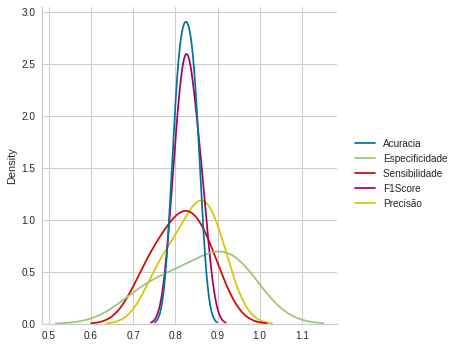

In [ ]:
sns.displot(dataframeT, kind="kde")

# ResNet resultados


In [ ]:
dataframeV, dataframeT = mtrcDF('resNet0010', 4)

In [ ]:
vec = [0.8,	0.9,	0.8666666667,	0.6666666667]
dataframeT.insert(loc = 4, column = 'Precisão', value = vec)

In [ ]:
dataframeT.describe()

Acuracia  Especificidade  Sensibilidade    F1Score  Precisão
count  4.000000        4.000000        4.000000  4.000000  4.000000
mean   0.816667        0.833333        0.817275  0.824506  0.808333
std    0.075768        0.038490        0.084520  0.060995  0.103190
min    0.716667        0.800000        0.705882  0.750000  0.666667
25%    0.779167        0.800000        0.776471  0.787500  0.766667
50%    0.833333        0.833333        0.833333  0.833333  0.833333
75%    0.870833        0.866667        0.874138  0.870339  0.875000
max    0.883333        0.866667        0.896552  0.881356  0.900000

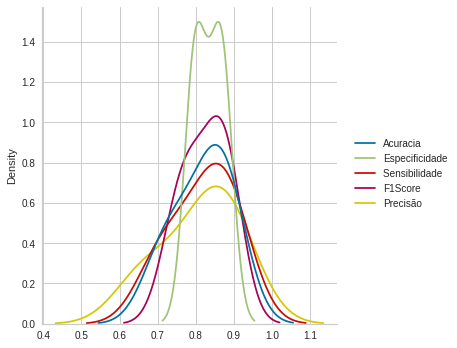

In [ ]:
sns.displot(dataframeT, kind="kde")

In [ ]:
dataframeV, dataframeT = mtrcDF('resNet00010', 4)

In [ ]:
vec = [0.8,	0.9,	0.73333333,	0.7]
dataframeT.insert(loc = 4, column = 'Precisão', value = vec)

In [ ]:
dataframeT.describe()

Acuracia  Especificidade  Sensibilidade    F1Score  Precisão
count  4.000000        4.000000        4.000000  4.000000  4.000000
mean   0.800000        0.825000        0.795002  0.808948  0.783333
std    0.054433        0.050000        0.075431  0.057231  0.088192
min    0.733333        0.766667        0.718750  0.741935  0.700000
25%    0.783333        0.791667        0.753217  0.785484  0.725000
50%    0.800000        0.833333        0.782353  0.806250  0.766667
75%    0.816667        0.866667        0.824138  0.829714  0.825000
max    0.866667        0.866667        0.896552  0.881356  0.900000

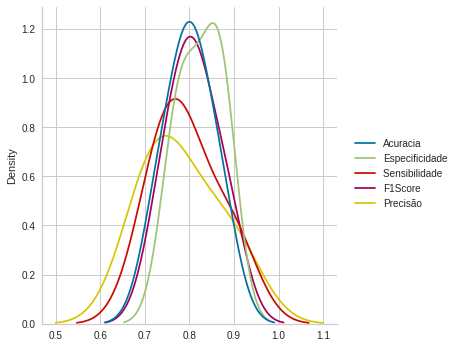

In [ ]:
sns.displot(dataframeT, kind="kde")

# Nova seção

In [ ]:
def lisToInt(lis):
  vec = []
  for i in lis:
    vec.append(int(i))
  return vec

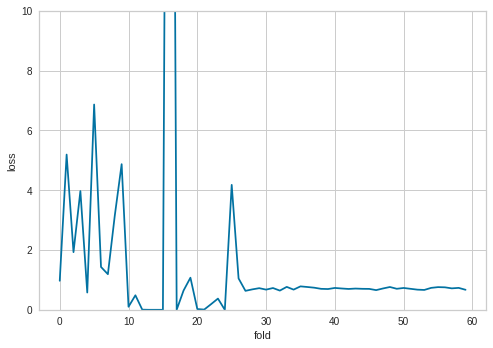

In [ ]:
vgg1600101 = [0.8463139533996582, 1.1181209087371826, 3.819204807281494, 2.035022497177124, 0.0011208925861865282, 0.10399234294891357, 0.00029774048016406596, 0.004486376419663429, 0.002466376405209303, 0.0, 0.20337139070034027, 0.11889683455228806, 0.008996782824397087, 0.0, 0.0, 1.3947389561508317e-05, 89.34453582763672, 0.0, 1.2876304388046265, 2.1476945877075195, 0.05111517384648323, 0.01507543958723545, 0.37669244408607483, 0.7501797080039978, 0.0, 7.641276836395264, 1.3533101081848145, 0.550826370716095, 0.6542714238166809, 0.7105528712272644, 0.7057875394821167, 0.6889379620552063, 0.6530561447143555, 0.7771400213241577, 0.60219806432724, 0.8165798187255859, 0.8043555617332458, 0.7622256875038147, 0.7287358045578003, 0.7172579765319824, 0.7155627608299255, 0.7027539610862732, 0.7026910781860352, 0.7117685079574585, 0.7111235857009888, 0.672156035900116, 0.6704447865486145, 0.6550746560096741, 0.7662774324417114, 0.7539283633232117, 0.7345518469810486, 0.7138766646385193, 0.6959633827209473, 0.7072863578796387, 0.6874725818634033, 0.7267423272132874, 0.7208529710769653, 0.6735957860946655, 0.7349305152893066, 0.6405063271522522]
vgg1600102 = [1.0955703258514404, 9.267313957214355, 0.035561371594667435, 5.908401012420654, 1.1554880142211914, 13.627302169799805, 2.865220546722412, 2.376436471939087, 6.291317939758301, 9.7431001663208, 0.0, 0.851773738861084, 0.0, 1.1920928244535389e-07, 0.0, 0.0, 0.0, 0.0021671399008482695, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7179602980613708, 0.7457271814346313, 0.7169166803359985, 0.712065577507019, 0.7366411685943604, 0.6438919305801392, 0.7674664258956909, 0.6313495635986328, 0.7557613253593445, 0.7478457689285278, 0.7511276602745056, 0.7211401462554932, 0.7166313529014587, 0.6739672422409058, 0.6714951992034912, 0.7463422417640686, 0.7224407196044922, 0.6919200420379639, 0.7091321349143982, 0.6924788951873779, 0.7265375852584839, 0.6459938287734985, 0.7723437547683716, 0.7590048313140869, 0.6518650650978088, 0.7261066436767578, 0.6903048753738403, 0.6520971059799194, 0.6210330724716187, 0.7799602746963501, 0.790187656879425, 0.7826533317565918, 0.7609145641326904, 0.7313129901885986, 0.6980820894241333]
vec3 = [(g + h) / 2 for g, h in zip(vgg1600101, vgg1600102)]
fig, ax = plt.subplots()
ax.set_ylim(0,10)
ax.set(xlabel='fold', ylabel='loss')
ax.plot(vec3)
plt.show()

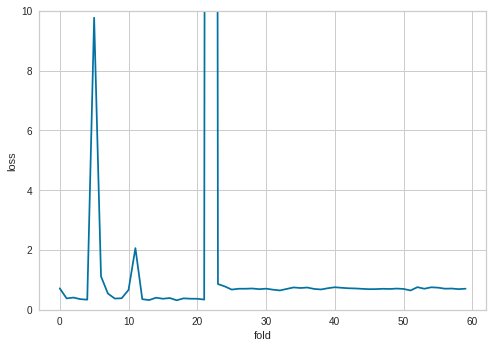

In [ ]:
vgg16000101 =[0.6276019215583801, 0.7633266448974609, 0.70829838514328, 0.7047933340072632, 0.6775668859481812, 0.709046483039856, 0.6746410727500916, 0.6346324682235718, 0.7528573274612427, 0.7295577526092529, 0.6983489394187927, 0.7109712362289429, 0.6849260926246643, 0.6505733132362366, 0.7748762965202332, 0.7397387027740479, 0.7375489473342896, 0.6361174583435059, 0.7666079998016357, 0.7417038083076477, 0.7162013649940491, 0.6845393180847168, 0.7427043914794922, 0.7125904560089111, 0.677736759185791, 0.709392786026001, 0.7017887830734253, 0.6993402242660522, 0.709918737411499, 0.6723679900169373, 0.7082947492599487, 0.6700529456138611, 0.643994927406311, 0.7548325657844543, 0.7221680283546448, 0.6953601241111755, 0.7348665595054626, 0.6439111232757568, 0.6398889422416687, 0.7803771495819092, 0.7876272201538086, 0.7708420157432556, 0.7347676157951355, 0.7192092537879944, 0.6996598243713379, 0.6843103170394897, 0.6787158846855164, 0.7162322402000427, 0.6908613443374634, 0.7333649396896362, 0.6677599549293518, 0.6503507494926453, 0.771133303642273, 0.7692198753356934, 0.7539871335029602, 0.727756917476654, 0.6905406713485718, 0.7094335556030273, 0.7122436165809631, 0.690899133682251]
vgg16000102 = [0.8077652454376221, 9.464769391342998e-05, 0.11055728048086166, 0.007930459454655647, 0.0, 18.829662322998047, 1.5620439052581787, 0.4535558521747589, 0.0, 0.04189632087945938, 0.6288081407546997, 3.4155871868133545, 0.025090377777814865, 0.0, 0.034375134855508804, 0.0, 0.04968390241265297, 0.0, 0.0, 0.0, 0.02139127068221569, 0.0, 357.80517578125, 1.0099247694015503, 0.8861570358276367, 0.6436558961868286, 0.7072283029556274, 0.7103765606880188, 0.7153485417366028, 0.7076506614685059, 0.7065311074256897, 0.6768636703491211, 0.6521401405334473, 0.6416411995887756, 0.7732192277908325, 0.7631247639656067, 0.7550498843193054, 0.750558078289032, 0.7215512990951538, 0.6648808717727661, 0.7209886312484741, 0.6994696259498596, 0.7058923840522766, 0.7089645862579346, 0.7022160887718201, 0.6958775520324707, 0.7071148753166199, 0.6894580721855164, 0.7026169300079346, 0.6868194937705994, 0.7277376055717468, 0.6430630087852478, 0.7428854703903198, 0.6404187679290771, 0.7505134344100952, 0.7542797327041626, 0.7222122550010681, 0.713029682636261, 0.670477032661438, 0.7203099131584167]
vec3 = [(g + h) / 2 for g, h in zip(vgg16000101, vgg16000102)]
fig, ax = plt.subplots()
ax.set_ylim(0,10)
ax.set(xlabel='fold', ylabel='loss')
ax.plot(vec3)
plt.show()

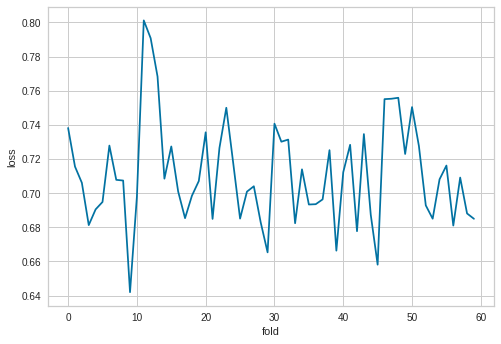

In [ ]:
vgg1900101 = [0.6276019215583801, 0.7633266448974609, 0.70829838514328, 0.7047933340072632, 0.6775668859481812, 0.709046483039856, 0.6746410727500916, 0.6346324682235718, 0.7528573274612427, 0.7295577526092529, 0.6983489394187927, 0.7109712362289429, 0.6849260926246643, 0.6505733132362366, 0.7748762965202332, 0.7397387027740479, 0.7375489473342896, 0.6361174583435059, 0.7666079998016357, 0.7417038083076477, 0.7162013649940491, 0.6845393180847168, 0.7427043914794922, 0.7125904560089111, 0.677736759185791, 0.709392786026001, 0.7017887830734253, 0.6993402242660522, 0.709918737411499, 0.6723679900169373, 0.7082947492599487, 0.6700529456138611, 0.643994927406311, 0.7548325657844543, 0.7221680283546448, 0.6953601241111755, 0.7348665595054626, 0.6439111232757568, 0.6398889422416687, 0.7803771495819092, 0.7876272201538086, 0.7708420157432556, 0.7347676157951355, 0.7192092537879944, 0.6996598243713379, 0.6843103170394897, 0.6787158846855164, 0.7162322402000427, 0.6908613443374634, 0.7333649396896362, 0.6677599549293518, 0.6503507494926453, 0.771133303642273, 0.7692198753356934, 0.7539871335029602, 0.727756917476654, 0.6905406713485718, 0.7094335556030273, 0.7122436165809631, 0.690899133682251]
vgg1900102 = [0.737438440322876, 0.7120713591575623, 0.7052804231643677, 0.6638124585151672, 0.6785358190536499, 0.7056244015693665, 0.7106031179428101, 0.6726817488670349, 0.6698522567749023, 0.6428056955337524, 0.7770386338233948, 0.792352020740509, 0.7844356298446655, 0.7490517497062683, 0.661794126033783, 0.7109457850456238, 0.6811665892601013, 0.6775690913200378, 0.6592399477958679, 0.7475479245185852, 0.7258044481277466, 0.7174468040466309, 0.6892858743667603, 0.7210522890090942, 0.6736155152320862, 0.71046382188797, 0.6855966448783875, 0.7023409605026245, 0.6768244504928589, 0.6744836568832397, 0.7408996224403381, 0.7128187417984009, 0.7136417627334595, 0.7049204707145691, 0.7078469395637512, 0.6689847707748413, 0.7128649353981018, 0.677289605140686, 0.7412005662918091, 0.6607990264892578, 0.7481700778007507, 0.7460839152336121, 0.6652045249938965, 0.7405672073364258, 0.7270320057868958, 0.6959456205368042, 0.7001217007637024, 0.6843702793121338, 0.7024415731430054, 0.6757155656814575, 0.7374368906021118, 0.7245538830757141, 0.6957011222839355, 0.7056407928466797, 0.6771436333656311, 0.711034893989563, 0.690031111240387, 0.7047393918037415, 0.6853232383728027, 0.7171028852462769]
vec3 = [(g + h) / 2 for g, h in zip(vgg1900101, vgg1900102)]
fig, ax = plt.subplots()
ax.set(xlabel='fold', ylabel='loss')
ax.plot(vec3)
plt.show()

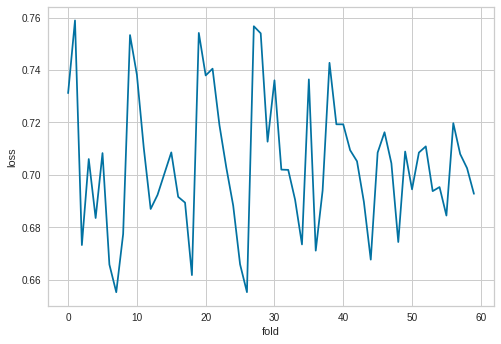

In [ ]:
vgg19000101 = [0.7305094003677368, 0.7141624093055725, 0.6702079176902771, 0.7108766436576843, 0.6960592269897461, 0.7001204490661621, 0.6658780574798584, 0.6322461366653442, 0.610123336315155, 0.7841200232505798, 0.7648464441299438, 0.7126874923706055, 0.6918120980262756, 0.6764388680458069, 0.6802918910980225, 0.7085259556770325, 0.6822439432144165, 0.6711134314537048, 0.6445322632789612, 0.7978253364562988, 0.7952702045440674, 0.767033576965332, 0.7315047979354858, 0.6981318593025208, 0.676611602306366, 0.6485133171081543, 0.6468693017959595, 0.7720037698745728, 0.7577236890792847, 0.7581732273101807, 0.7291133999824524, 0.6888423562049866, 0.7040903568267822, 0.7072519063949585, 0.6771387457847595, 0.733783483505249, 0.6743869781494141, 0.6485637426376343, 0.7699190974235535, 0.7530975937843323, 0.7298031449317932, 0.7166465520858765, 0.7045629024505615, 0.6774536967277527, 0.6550778746604919, 0.742259681224823, 0.7190623879432678, 0.6993266940116882, 0.6774518489837646, 0.6762830018997192, 0.6729590892791748, 0.7169606685638428, 0.716362476348877, 0.7143204212188721, 0.7157992124557495, 0.692559540271759, 0.7005333304405212, 0.6927159428596497, 0.7133112549781799, 0.6951590776443481]
vgg19000102 = [0.7318490743637085, 0.8037580847740173, 0.6760993003845215, 0.7011651396751404, 0.6709050536155701, 0.7164621353149414, 0.6655995845794678, 0.6780562996864319, 0.7446252107620239, 0.7226102948188782, 0.7115339040756226, 0.7077942490577698, 0.6820684671401978, 0.7081968188285828, 0.7206349968910217, 0.7085784077644348, 0.7009184956550598, 0.7076214551925659, 0.6788228154182434, 0.7105488181114197, 0.6806168556213379, 0.7140147686004639, 0.7064623832702637, 0.7073573470115662, 0.6998888254165649, 0.6830973625183105, 0.6634662747383118, 0.7414577007293701, 0.7503377199172974, 0.6671047210693359, 0.7430588603019714, 0.7151033282279968, 0.6996644139289856, 0.6736591458320618, 0.6696453094482422, 0.7390620708465576, 0.6676589250564575, 0.7393859624862671, 0.7156244516372681, 0.6854690909385681, 0.7087239623069763, 0.7021499872207642, 0.7057608366012573, 0.7018793821334839, 0.680094301700592, 0.6746662855148315, 0.7134230732917786, 0.709449827671051, 0.6711704730987549, 0.7414771914482117, 0.7159149646759033, 0.7000001072883606, 0.7053277492523193, 0.673184335231781, 0.674818217754364, 0.6763005256652832, 0.7388975620269775, 0.7231422662734985, 0.6917486190795898, 0.6902973651885986]
vec3 = [(g + h) / 2 for g, h in zip(vgg19000101, vgg19000102)]
fig, ax = plt.subplots()
ax.set(xlabel='fold', ylabel='loss')
ax.plot(vec3)
plt.show()

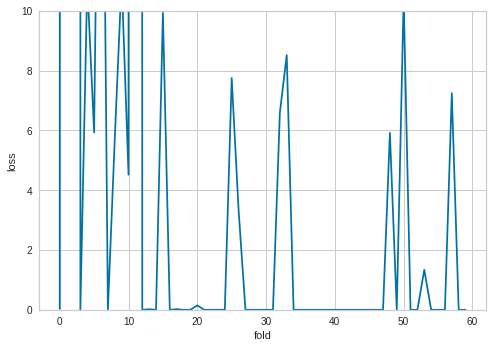

In [ ]:
inceo00101 = [0.0006866481271572411, 7235.560546875, 61315.859375, 3.576278118089249e-07, 0.06338578462600708, 0.0, 50.47266387939453, 0.012700389139354229, 11.415801048278809, 22.120532989501953, 9.037309646606445, 149.0792236328125, 0.0, 0.03622691333293915, 0.0, 5.960446742392378e-06, 0.0, 0.04468875378370285, 0.0, 0.0012400802224874496, 0.2971816658973694, 1.1920928244535389e-07, 0.0, 0.0028715587686747313, 0.0002294515579706058, 0.0, 6.6864471435546875, 0.0, 6.556489552167477e-06, 5.245195097813848e-06, 0.0, 0.0, 13.179689407348633, 0.025878744199872017, 0.0, 0.0, 0.0, 0.0, 0.0007556205382570624, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.152531907195225e-06, 0.0, 0.0, 11.835481643676758, 2.288792165927589e-05, 20.863319396972656, 0.0, 0.0, 2.677175521850586, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
incep00102 = [0.06319443881511688, 0.0, 0.0, 0.0, 21.808879852294922, 11.861555099487305, 4.768370445162873e-07, 0.0016465928638353944, 0.010827246122062206, 0.001334729720838368, 0.0, 1379.80517578125, 0.0, 0.0, 0.0, 19.864707946777344, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.8000440832111053e-05, 0.0, 0.0, 15.505894660949707, 0.0, 0.0, 1.1920928244535389e-07, 0.0, 0.0, 0.0, 0.0, 17.015718460083008, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00010883215873036534, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.49279499053955, 0.0, 0.0]
vec3 = [(g + h) / 2 for g, h in zip(inceo00101, incep00102)]
fig, ax = plt.subplots()
ax.set_ylim(0,10)
ax.set(xlabel='fold', ylabel='loss')
ax.plot(vec3)
plt.show()

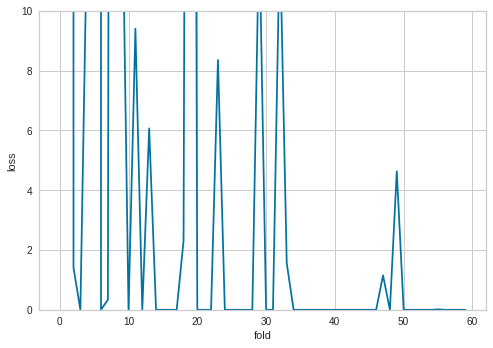

In [ ]:
inceo000101 = [0.0018929197685793042, 5924.951171875, 1.1920928244535389e-07, 0.0, 26.27398109436035, 3247.70751953125, 0.0, 0.6674792766571045, 230.61245727539062, 30.947235107421875, 0.0, 18.798873901367188, 0.0005078217945992947, 1.713234782218933, 0.0, 0.0, 0.0, 0.0, 4.608756065368652, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.529942543740617e-06, 0.0, 0.0, 0.0, 17.232685089111328, 0.0, 0.0, 0.0, 0.00018153927521780133, 1.5735502529423684e-05, 0.0005534547381103039, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00030655929003842175, 0.0, 0.0, 0.0, 1.1920928244535389e-07, 0.0, 0.0, 0.0, 1.490105023549404e-05, 0.0, 0.0, 0.0, 0.0, 0.0]
incep000102 = [141.494384765625, 661.9520263671875, 2.81465220451355, 7.152555099310121e-07, 0.0, 0.0, 0.0, 0.008036185055971146, 13.769353866577148, 4.756337511935271e-05, 0.0, 0.0, 0.0, 10.419804573059082, 0.0, 0.0, 0.0, 0.0, 0.0, 147.46890258789062, 0.0, 0.0, 7.891343557275832e-05, 16.709148406982422, 0.0, 0.0, 0.0, 0.0, 0.0, 8.403772354125977, 1.9073468138230965e-06, 0.0, 25.150928497314453, 3.1277129650115967, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3044488430023193, 0.0, 9.265793800354004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.028822414577007294, 0.0, 0.0, 0.0, 0.0]
vec3 = [(g + h) / 2 for g, h in zip(inceo000101, incep000102)]
fig, ax = plt.subplots()
ax.set_ylim(0,10)
ax.set(xlabel='fold', ylabel='loss')
ax.plot(vec3)
plt.show()

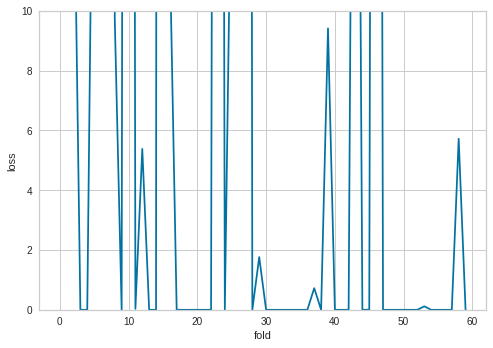

In [ ]:
resn00101 = [95.22396087646484, 2239.27490234375, 0.0, 0.0, 0.0, 42.09738540649414, 147.24081420898438, 0.01192464865744114, 12.948657989501953, 0.0, 269.905517578125, 0.04046082869172096, 0.0, 0.0, 0.0, 629.0386352539062, 24.126461029052734, 0.0, 6.4490144723095e-05, 0.0, 0.0, 0.0, 0.00048315772437490523, 200.38414001464844, 0.0, 0.0, 43.87158966064453, 326.7283935546875, 0.0, 3.5256154537200928, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4467594623565674, 0.0, 18.824121475219727, 0.0, 0.0, 0.0, 57.852108001708984, 0.0, 0.0, 183.83065795898438, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23349560797214508, 0.0, 0.0, 3.576278118089249e-07, 0.0, 11.440592765808105, 0.0]
resn00102 = [1483.38037109375, 0.0, 32.36376953125, 0.0, 0.0, 0.0, 90.02442169189453, 561.632080078125, 6.520931243896484, 0.0, 0.0, 0.025738641619682312, 10.759700775146484, 0.0, 0.0, 1.07287787614041e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0025631689932197332, 32.45489501953125, 0.0, 0.0, 0.0, 1.1920928244535389e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0490362910786644e-05, 0.0, 0.0, 0.0, 17.425037384033203, 0.0, 0.007244863081723452, 0.0, 0.0, 4.768370445162873e-07, 0.0, 2.7418097943154862e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
vec3 = [(g + h) / 2 for g, h in zip(resn00101, resn00102)]
fig, ax = plt.subplots()
ax.set(xlabel='fold', ylabel='loss')
ax.set_ylim(0,10)
ax.plot(vec3)
plt.show()

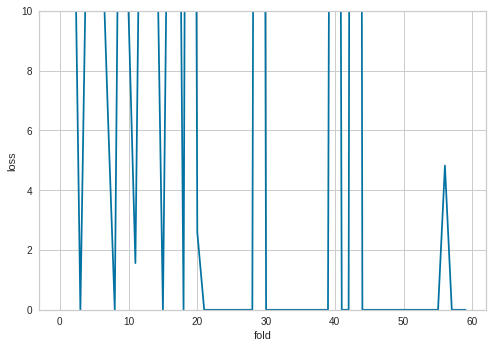

In [ ]:
resn000101 = [1486.32177734375, 0.0, 14.977115631103516, 0.0, 28.552093505859375, 30.514976501464844, 3.576278118089249e-07, 13.115594863891602, 0.0, 51.45008087158203, 0.0, 3.1252779960632324, 43.2690544128418, 0.0, 8.219076156616211, 1.1920928244535389e-07, 42.767578125, 8.775354385375977, 0.0, 5.2569914259947836e-05, 5.175268173217773, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 187.77236938476562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 155.5673828125, 0.0, 0.0, 254.55593872070312, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.643821716308594, 0.0, 0.0, 1.4305104514278355e-06]
resn000102 = [0.0, 1332.263671875, 17.174453735351562, 0.0, 0.0, 8.4638240878121e-06, 27.143543243408203, 0.0, 0.0, 3.45700973412022e-05, 19.941123962402344, 0.0002740246127359569, 0.0, 42.91954040527344, 21.092321395874023, 3.3378546504536644e-06, 0.0, 47.39717102050781, 1.1920928244535389e-07, 129.81703186035156, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00017867876158561558, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
vec3 = [(g + h) / 2 for g, h in zip(resn000101, resn000102)]
fig, ax = plt.subplots()
ax.set_ylim(0,10)
ax.set(xlabel='fold', ylabel='loss')
ax.plot(vec3)
plt.show()

In [ ]:
!python

Python 3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> 
KeyboardInterrupt
>>> 
KeyboardInterrupt
>>> 
KeyboardInterrupt
>>> ^C
